## **Predicción de supervivencia post-transplante de células HCT**

El conjunto de datos consta de 59 variables relacionadas con el transplante de células madre hematopoyéticas (HSCT), que abarcan una gama de características demográficas y médicas tanto de los receptores como de los donantes, como la edad, el sexo, la etnia, el estado de la enfermedad y los detalles del tratamiento. El resultado principal de interés es la supervivencia libre de eventos, representada por la variable **efs**, mientras que el tiempo de supervivencia libre de eventos es capturado por la variable **efs_time**. Estas dos variables juntas codifican el objetivo para un análisis censurado de tiempo a evento. Los datos, que presentan una representación igualitaria en todas las categorías raciales de los destinatarios, incluyendo blancos, asiáticos, afroamericanos, nativos americanos, isleños del Pacífico y más de una raza, se generaron sintéticamente utilizando el generador de datos de synthcity.

## **Importar librerías necesarias**

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay, auc


## **Parte1: Análisis Predictivo: Clasificación de la variable *efs***

Esta primera parte del proyecto, se centra en contruir un modelo para predecir la variable **efs**, que indica si ha ocurrido un evento (recaída, muerte, etc.) tras el transplante.

Se enfocará únicamente en la **clasificación binaria**, dejando la predicción del tiempo (**efs_time**) para una segunda fase.


### **1.Cargar y explorar el dataset**

Leemos el archivo que contiene la información clínica y genética de los pacientes.

In [48]:
df = pd.read_csv('data.csv')
df.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


**Información general de los datos**

En primer lugar, se observa la información que contiene el conjunto de datos: tamaño, tipo de variables, registros nulos, etc.

In [49]:
print('Tamaño del dataset:', df.shape)
print('Información general del dataset:')
df.info()


Tamaño del dataset: (28800, 60)
Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      28800 non-null  int64  
 1   dri_score               28646 non-null  object 
 2   psych_disturb           26738 non-null  object 
 3   cyto_score              20732 non-null  object 
 4   diabetes                26681 non-null  object 
 5   hla_match_c_high        24180 non-null  float64
 6   hla_high_res_8          22971 non-null  float64
 7   tbi_status              28800 non-null  object 
 8   arrhythmia              26598 non-null  object 
 9   hla_low_res_6           25530 non-null  float64
 10  graft_type              28800 non-null  object 
 11  vent_hist               28541 non-null  object 
 12  renal_issue             26885 non-null  object 
 13  pulm_severe             26

In [50]:
print('Valores nulos del dataset por columnas:')

missing_values = df.isnull().sum()
missing_values_percentage = (missing_values / len(df)) * 100
missing_values_percentage

print('Mayor porcentaje de valores nulos:', missing_values_percentage.max())

Valores nulos del dataset por columnas:
Mayor porcentaje de valores nulos: 65.95833333333333


### **2.Eliminamos aquellas columnas que tienen más de un 30% de valores nulos**

Las columnas con demasiados valores perdidos pueden aportar poco valor y sesgar el modelo, así que las eliminamos.

In [51]:
columns_to_drop = missing_values_percentage[missing_values_percentage > 30].index.tolist()
df_cleaned = df.drop(columns=columns_to_drop)
print('Tamaño del dataset:', df_cleaned.shape)
df_cleaned.info()

Tamaño del dataset: (28800, 55)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 55 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      28800 non-null  int64  
 1   dri_score               28646 non-null  object 
 2   psych_disturb           26738 non-null  object 
 3   cyto_score              20732 non-null  object 
 4   diabetes                26681 non-null  object 
 5   hla_match_c_high        24180 non-null  float64
 6   hla_high_res_8          22971 non-null  float64
 7   tbi_status              28800 non-null  object 
 8   arrhythmia              26598 non-null  object 
 9   hla_low_res_6           25530 non-null  float64
 10  graft_type              28800 non-null  object 
 11  vent_hist               28541 non-null  object 
 12  renal_issue             26885 non-null  object 
 13  pulm_severe             26665 non-null  object 
 14  prim_d

### **3.Eliminamos columnas innecesarias**

* La columna **ID** es un identificador y no contiene información útil para el modelo.
* Para esta parte del problema, se va a eliminar la columna **efs_time**

In [52]:
# Eliminar columna ID si está presente
if 'ID' in df_cleaned.columns:
    df_cleaned = df_cleaned.drop(columns=['ID'])

In [53]:
# Eliminar columna ID si está presente
if 'efs_time' in df_cleaned.columns:
    df_cleaned = df_cleaned.drop(columns=['efs_time'])

### **4.Separación en conjunto de entrenamiento y test**

In [54]:
#División en características y variable objetivo
X = df_cleaned.drop(columns=['efs'])
y = df_cleaned['efs']

In [55]:
#Separación train/test antes del preprocesamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **5.Análisis de las variables**

#### **Observando variables**

/var/folders/fh/kgv89nmn07vbkcp8m7zl79m00000gn/T/ipykernel_87489/115818919.py:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


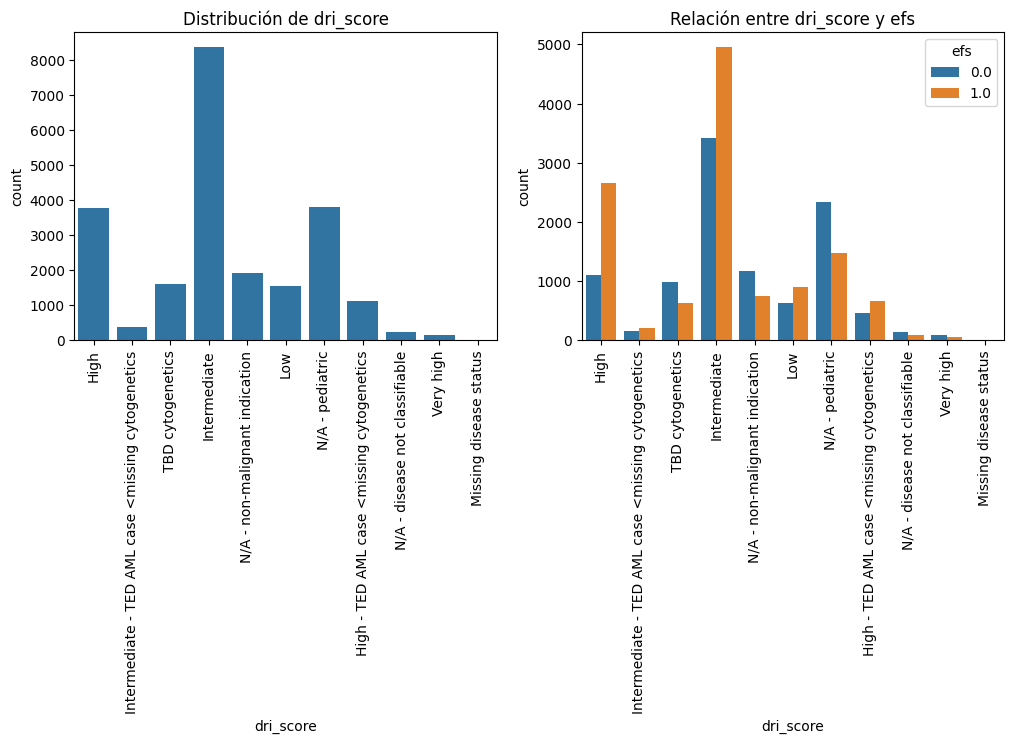

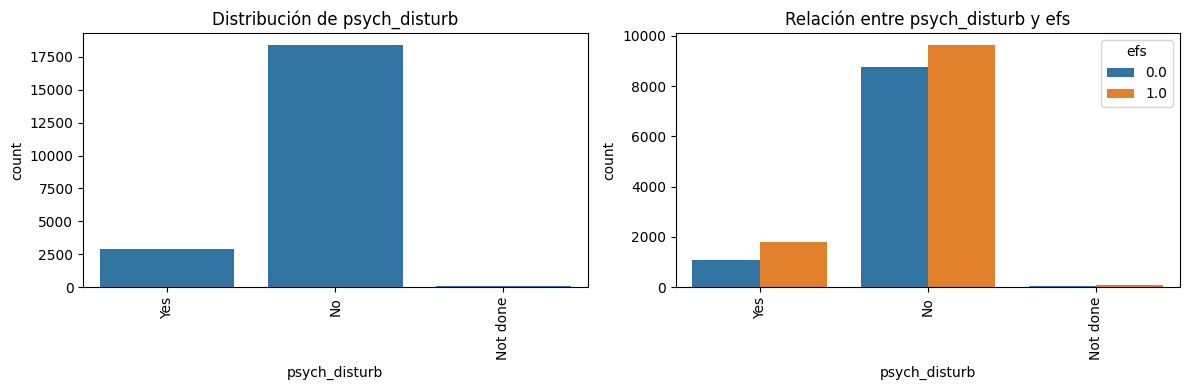

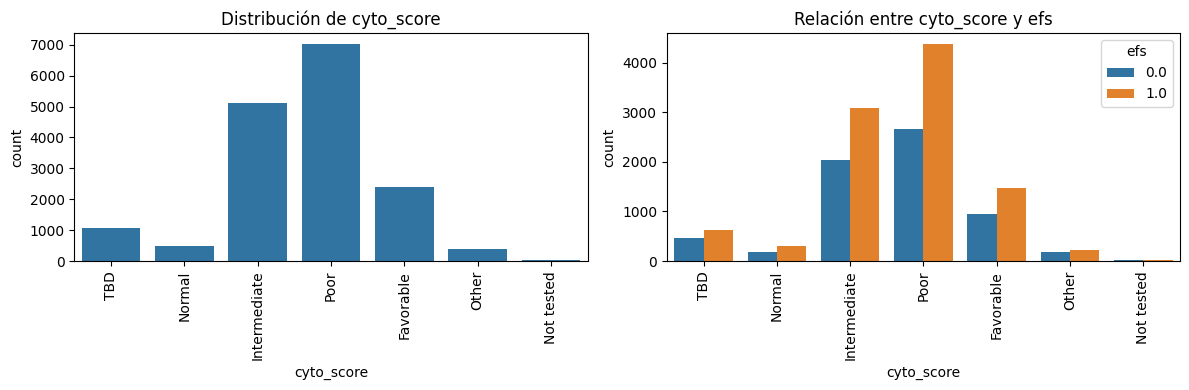

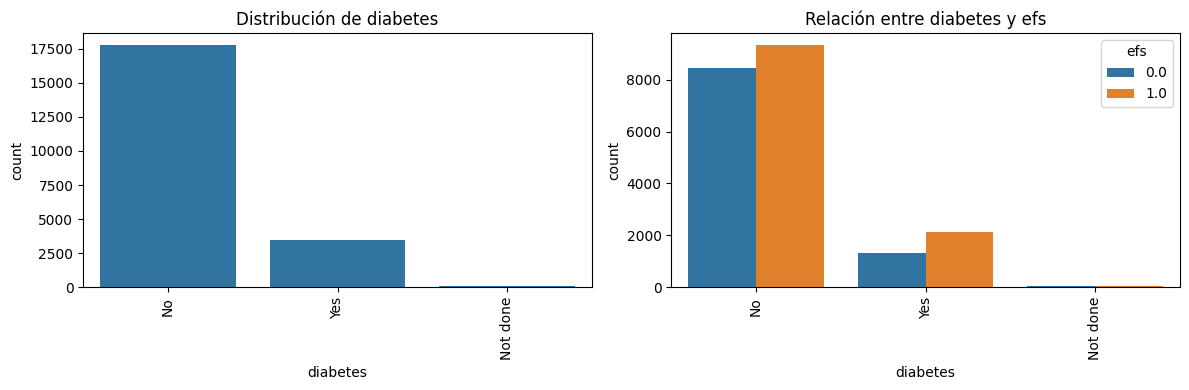

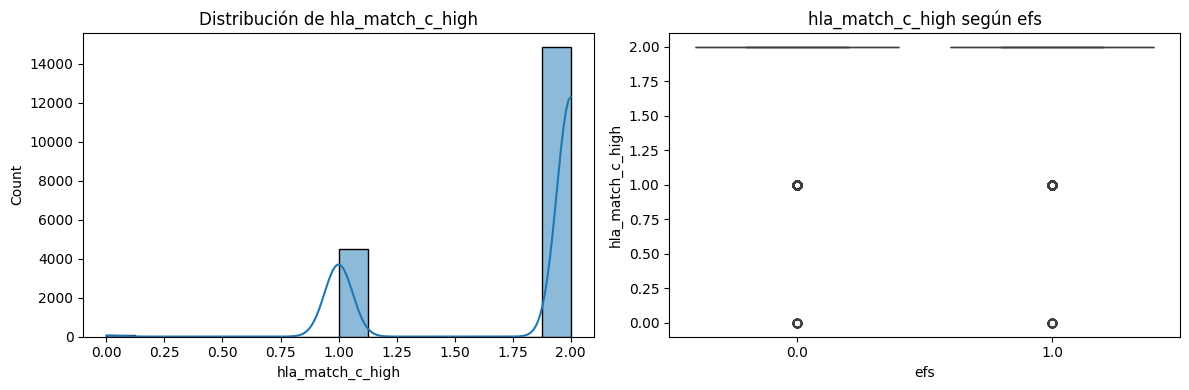

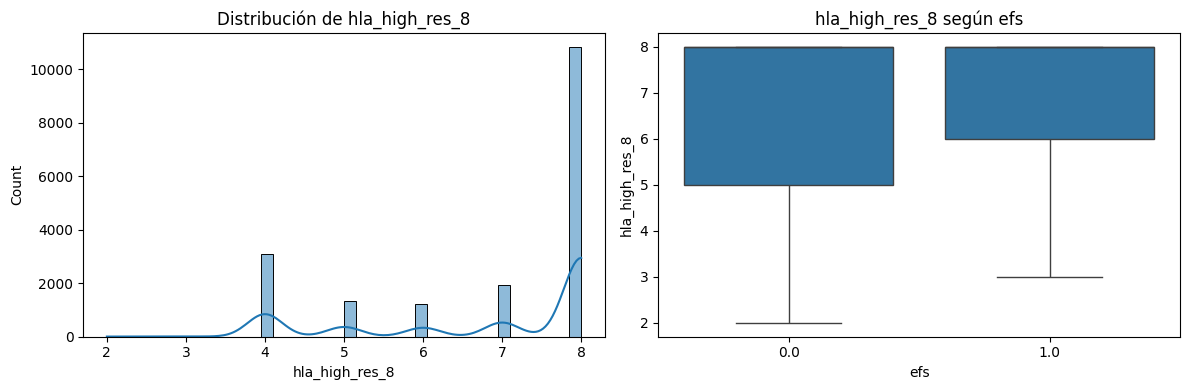

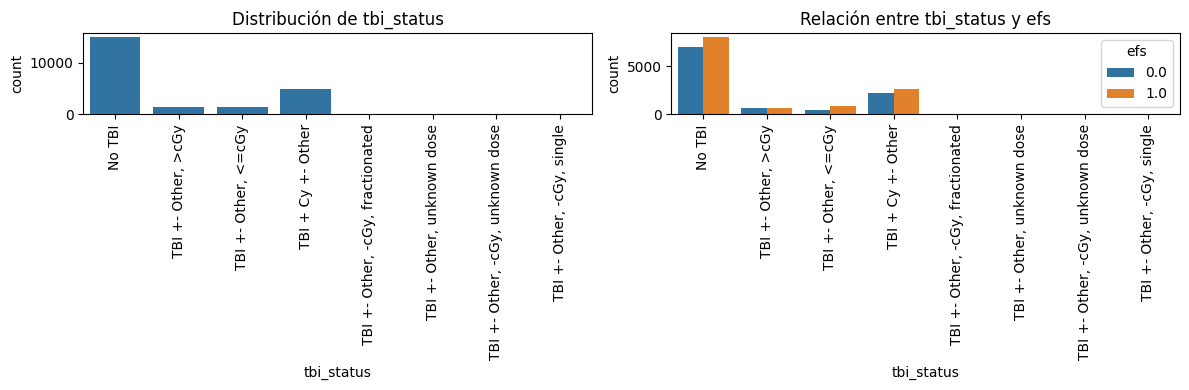

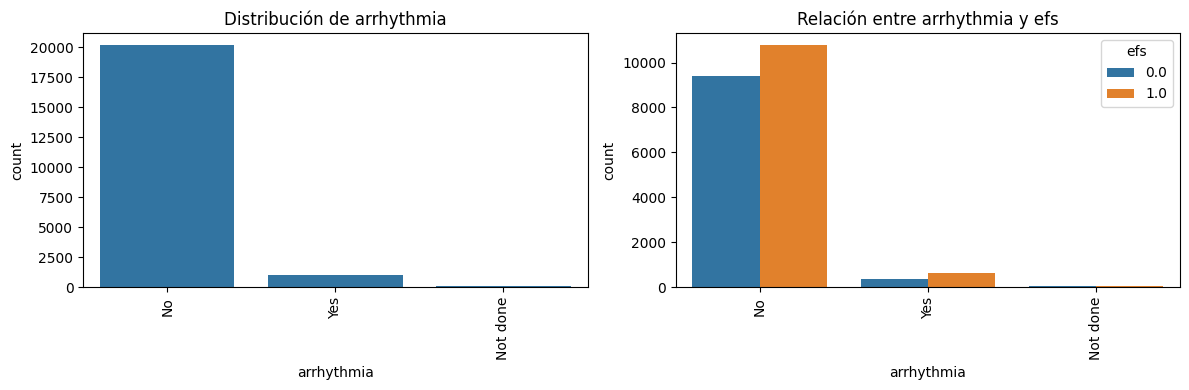

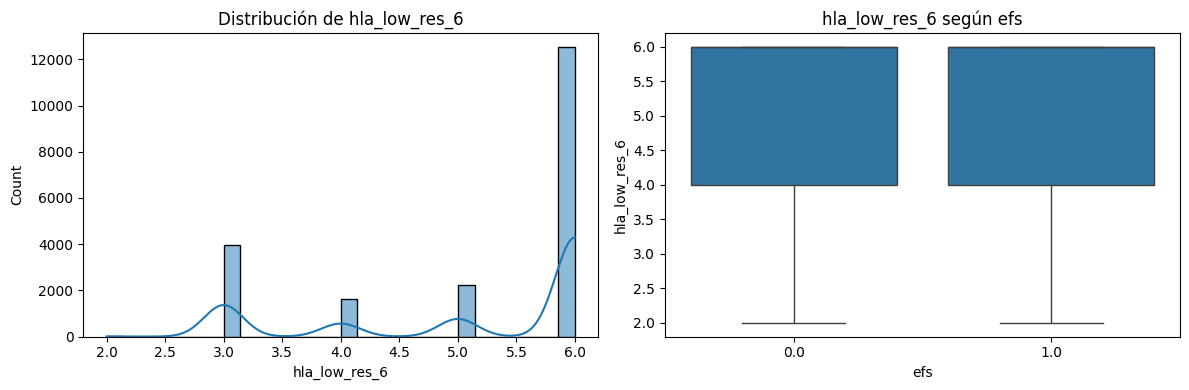

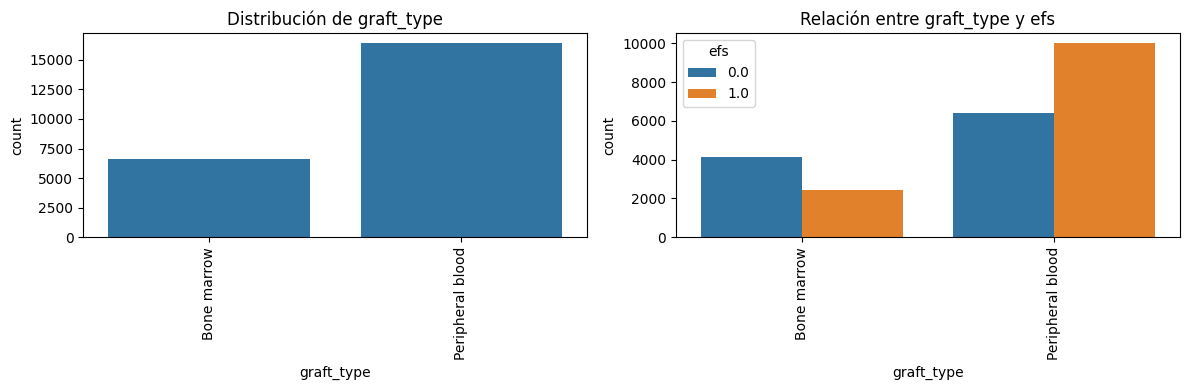

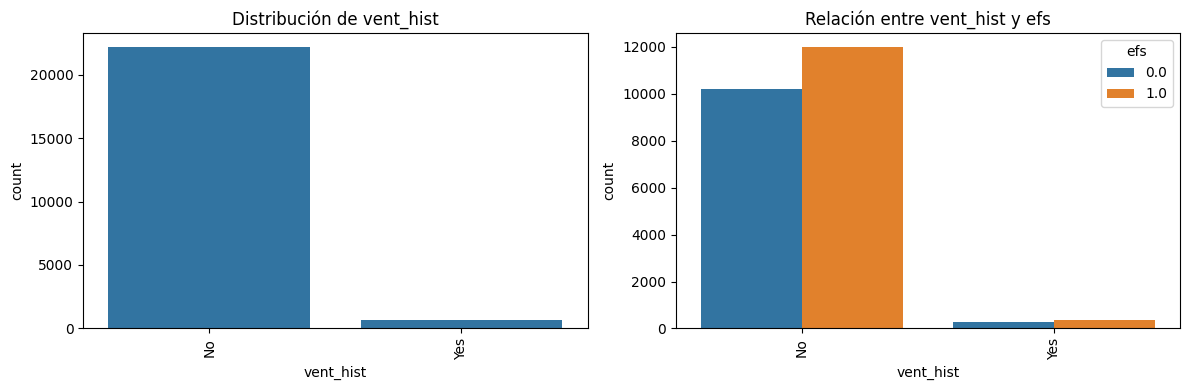

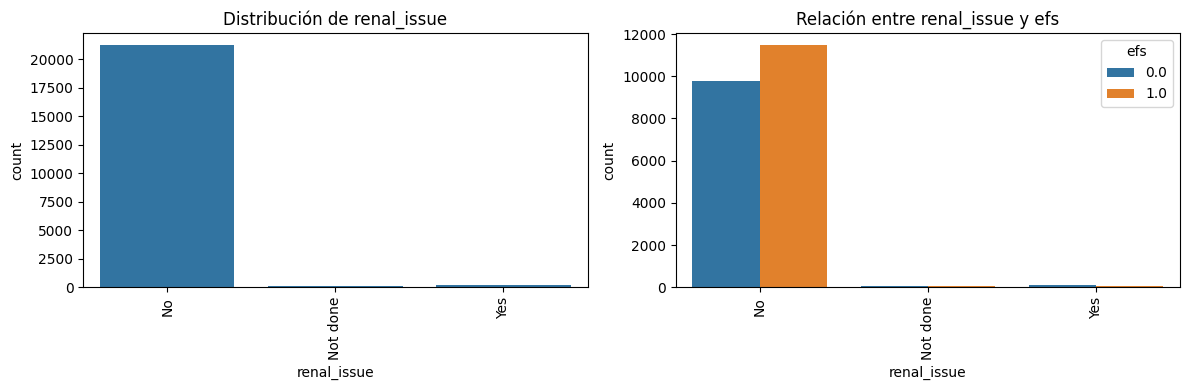

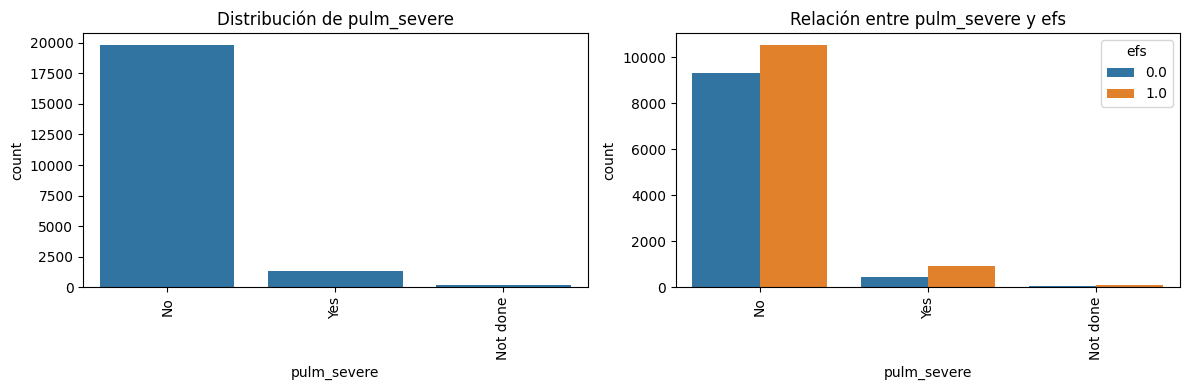

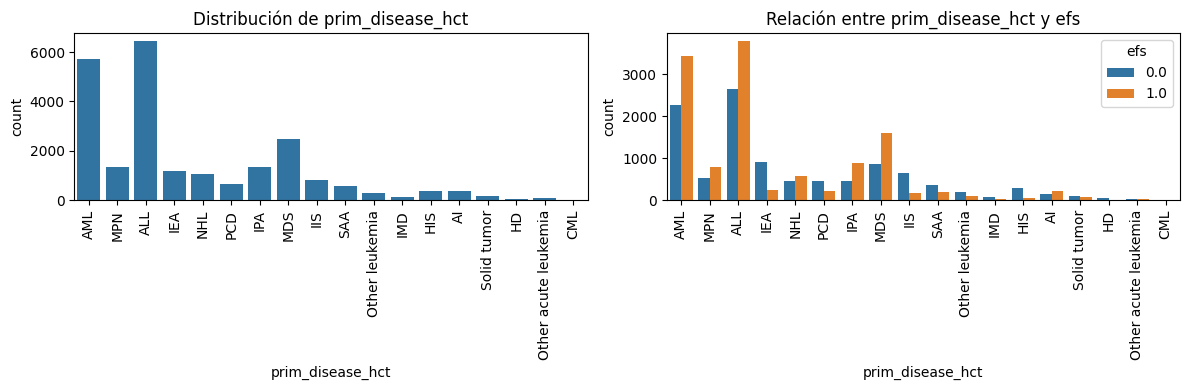

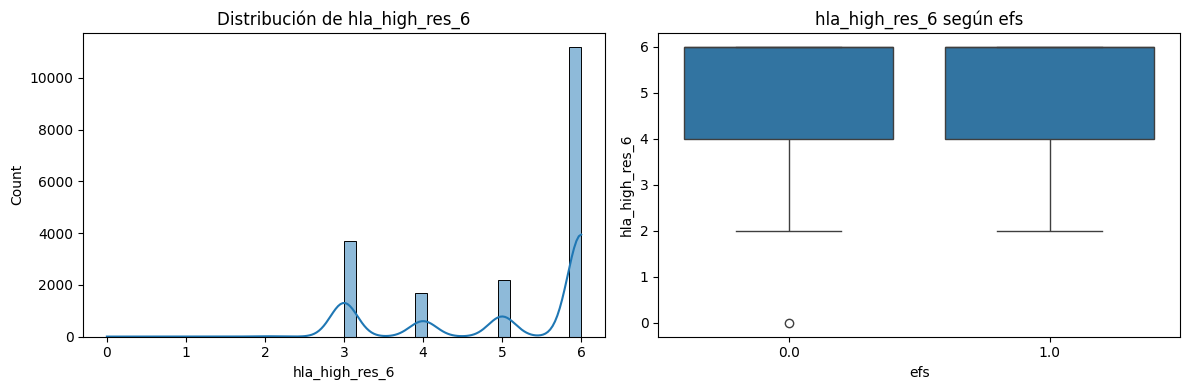

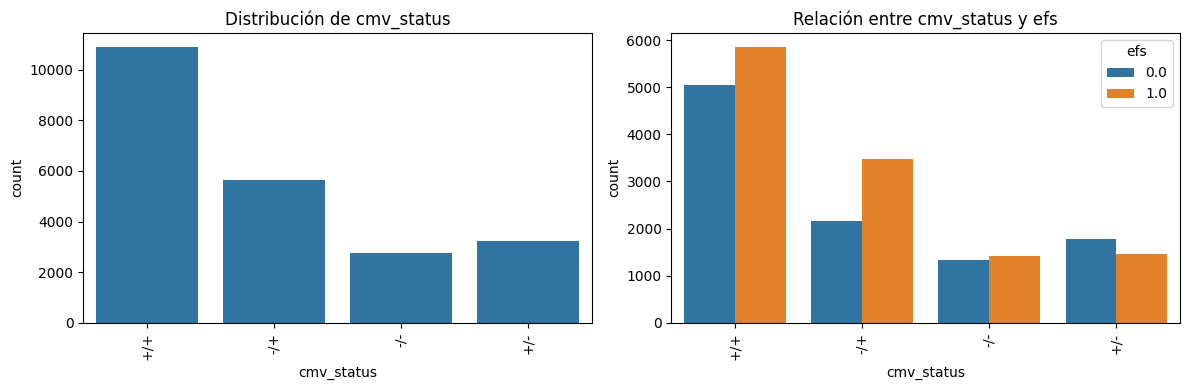

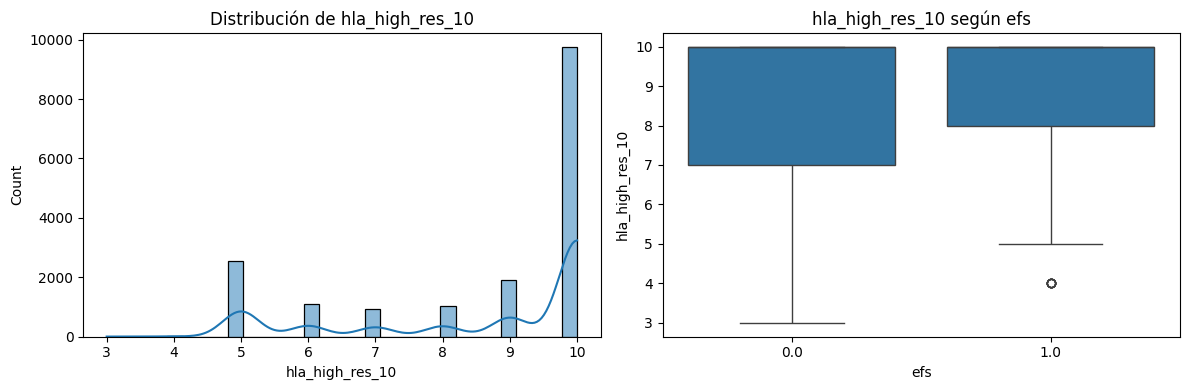

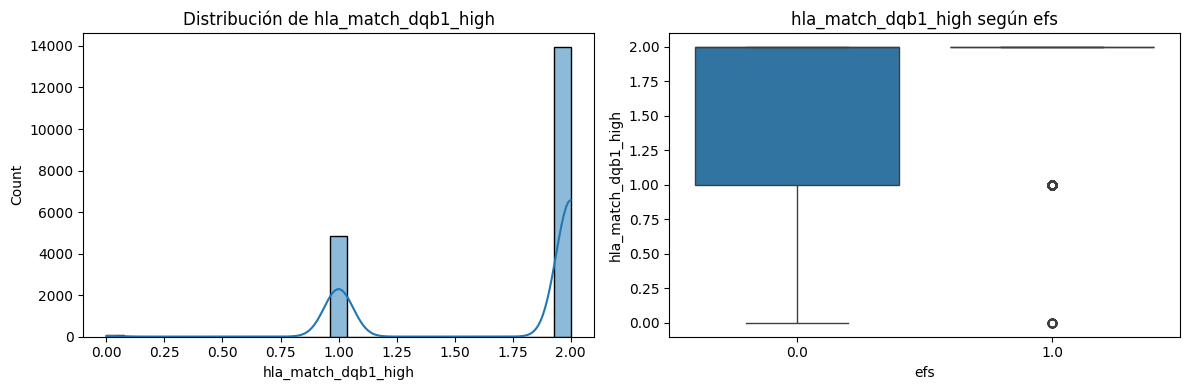

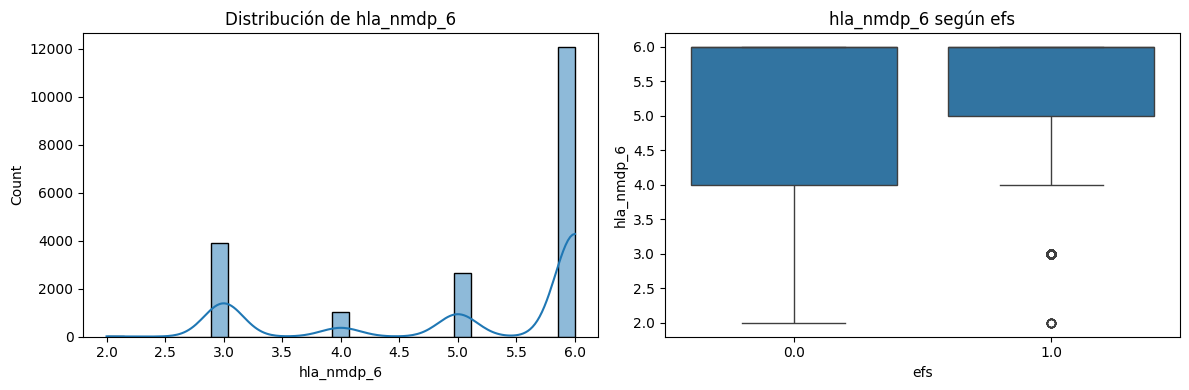

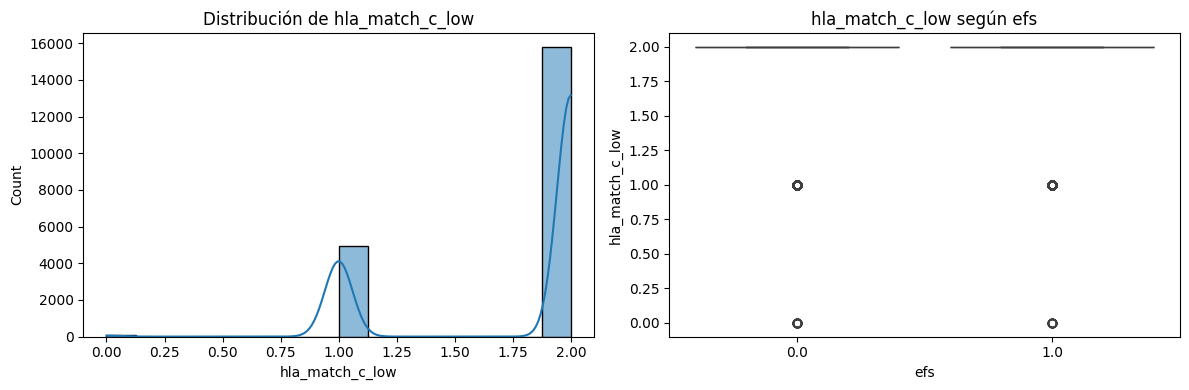

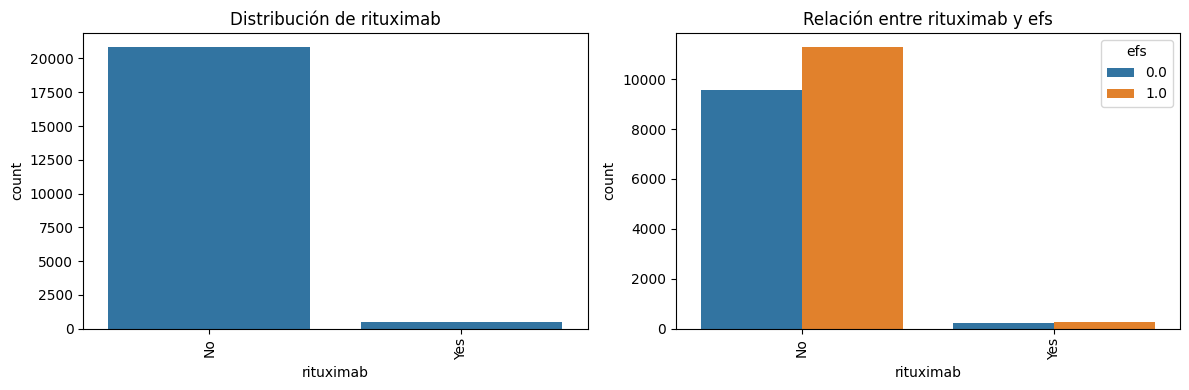

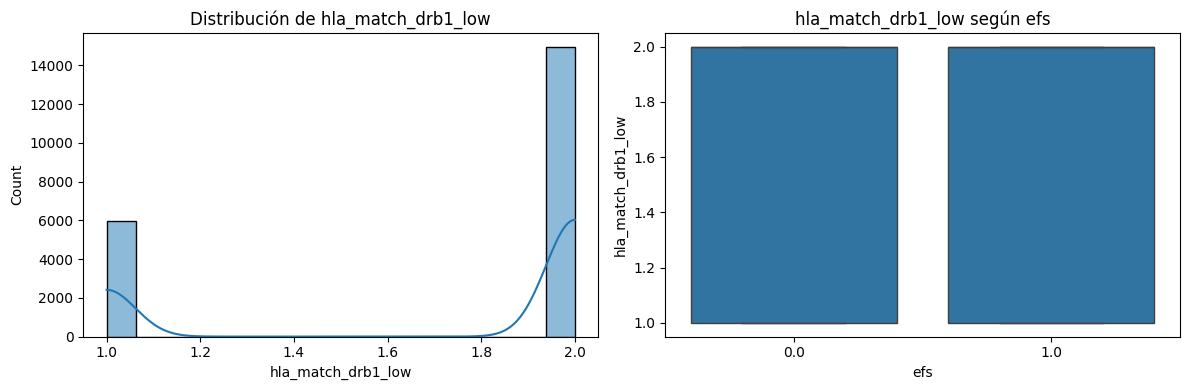

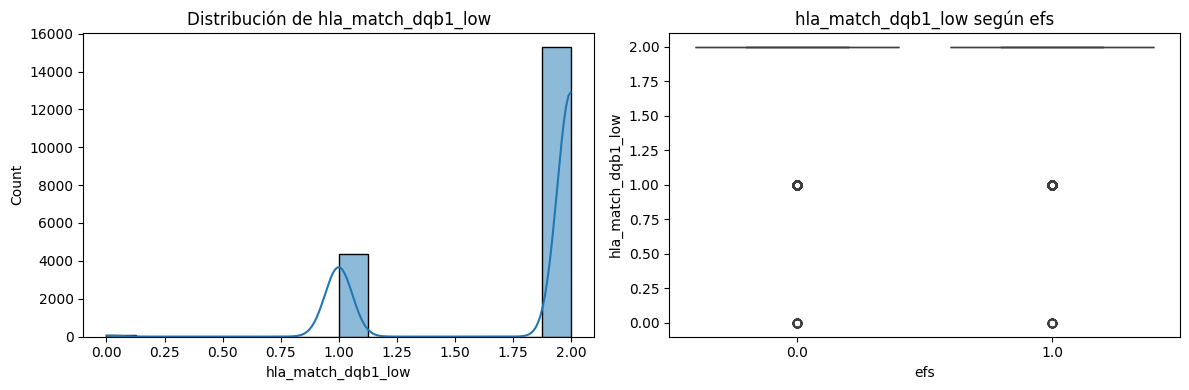

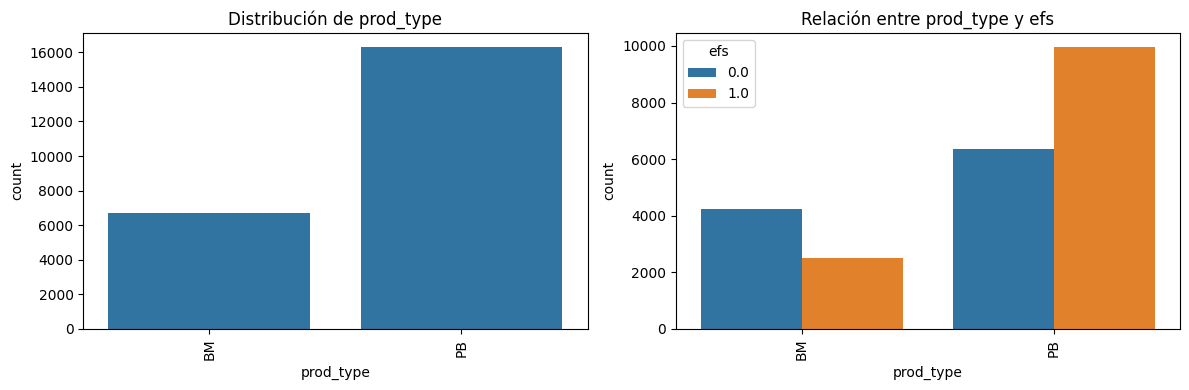

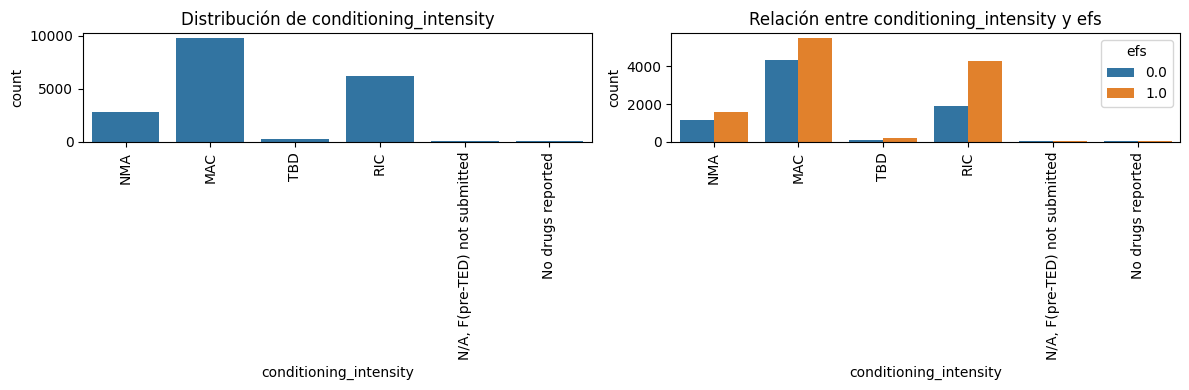

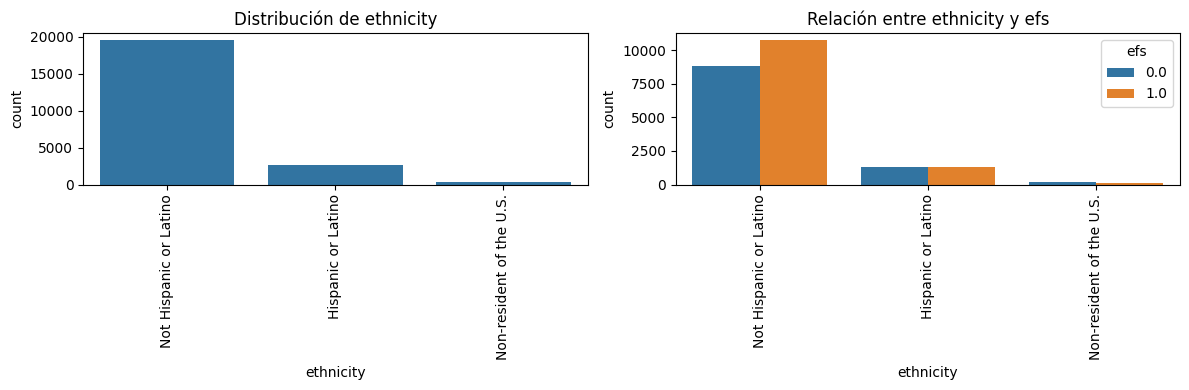

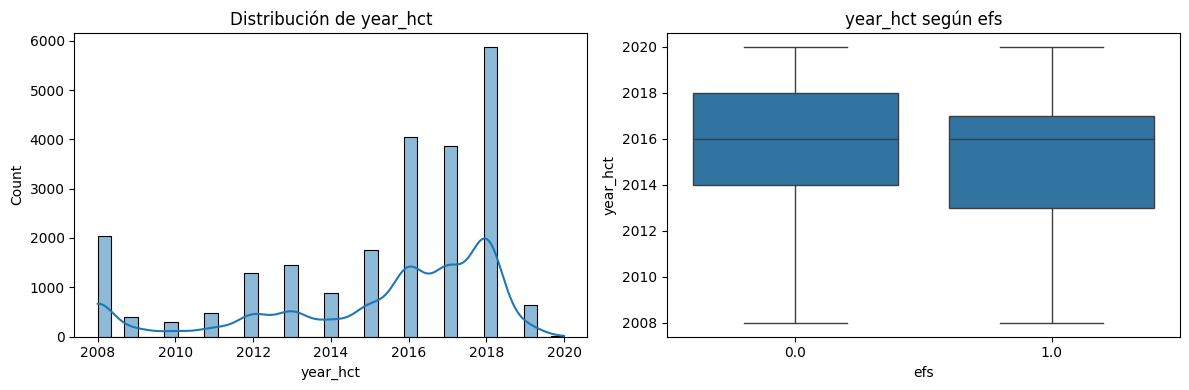

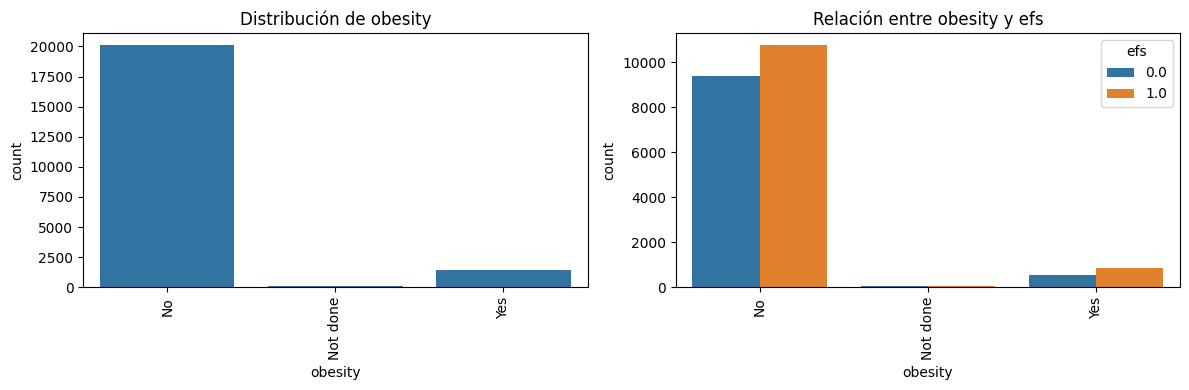

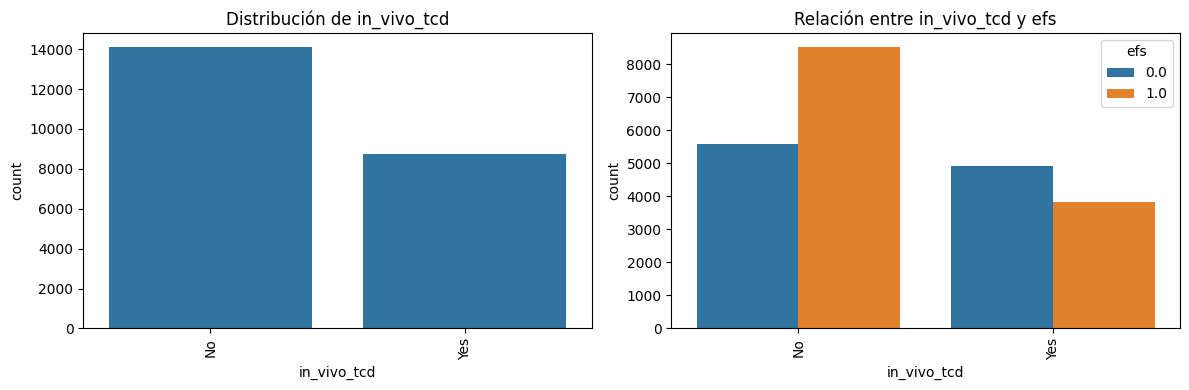

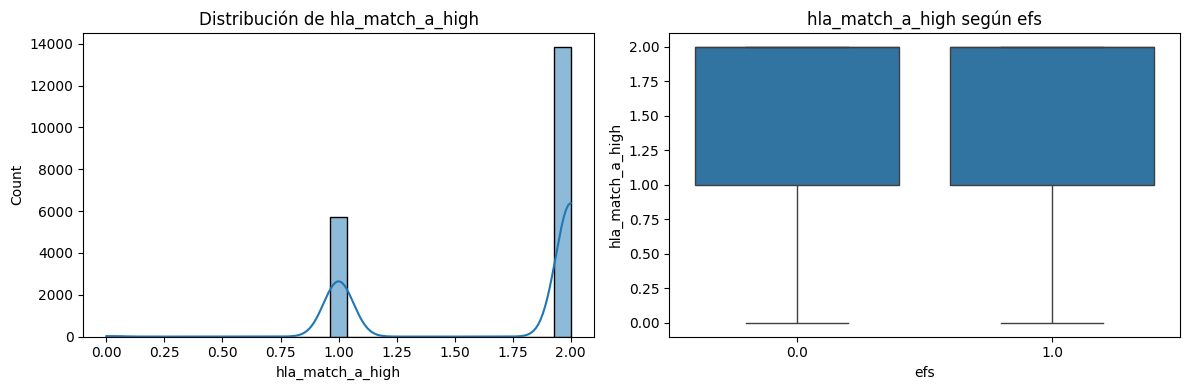

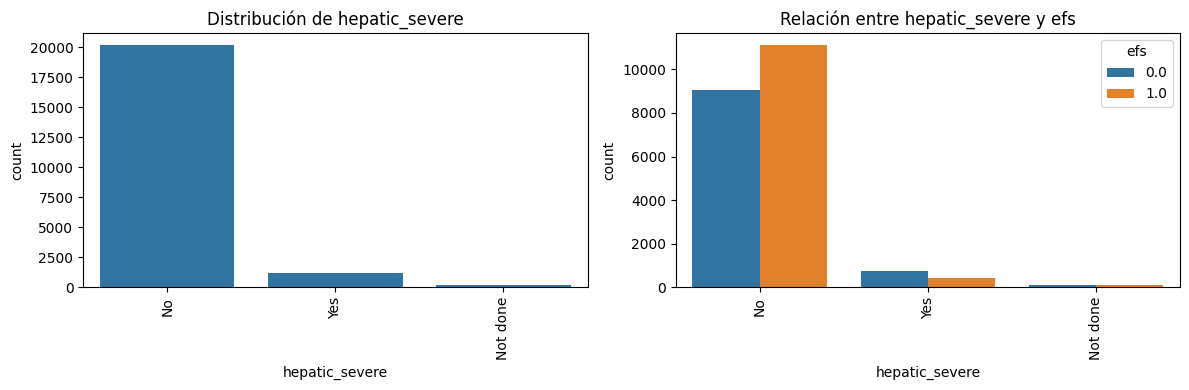

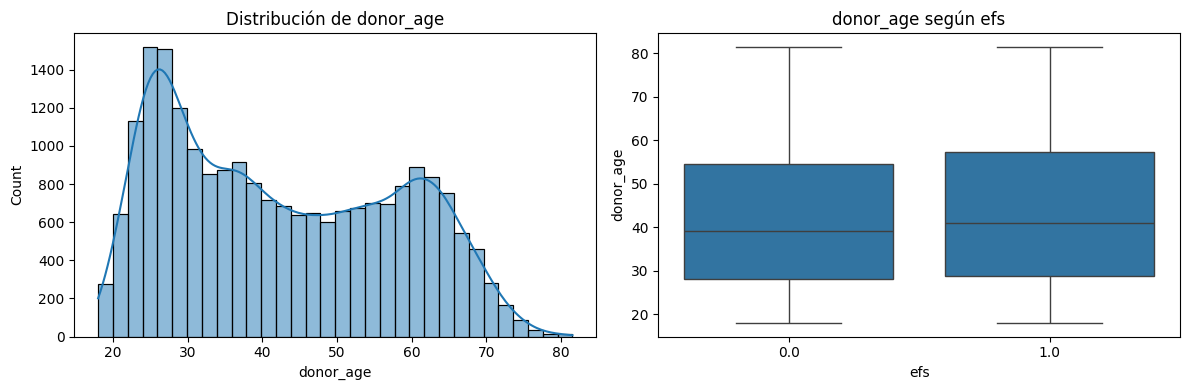

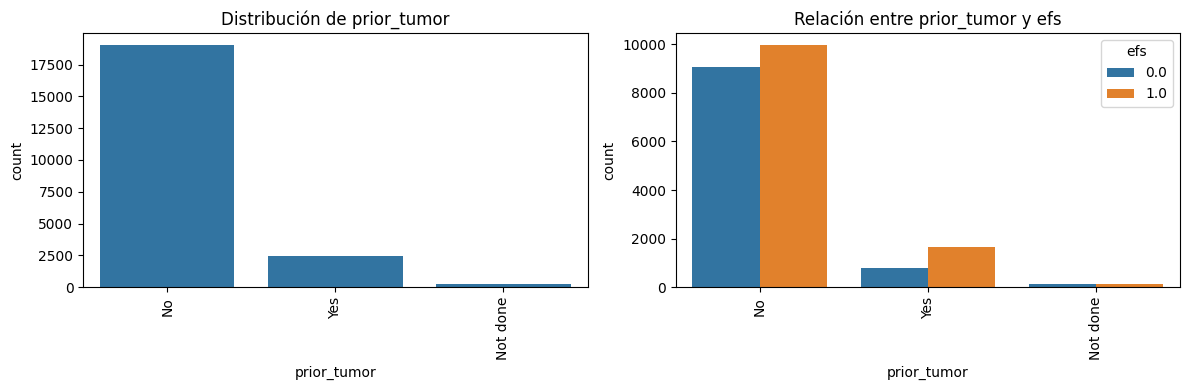

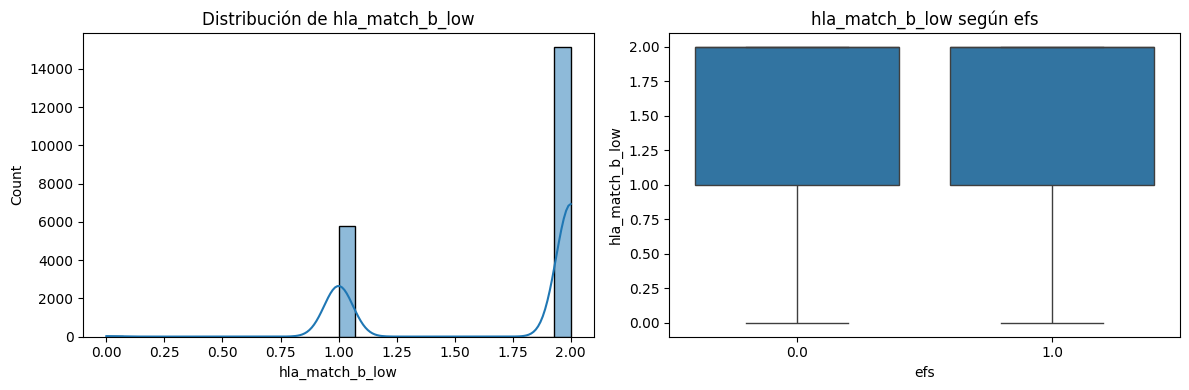

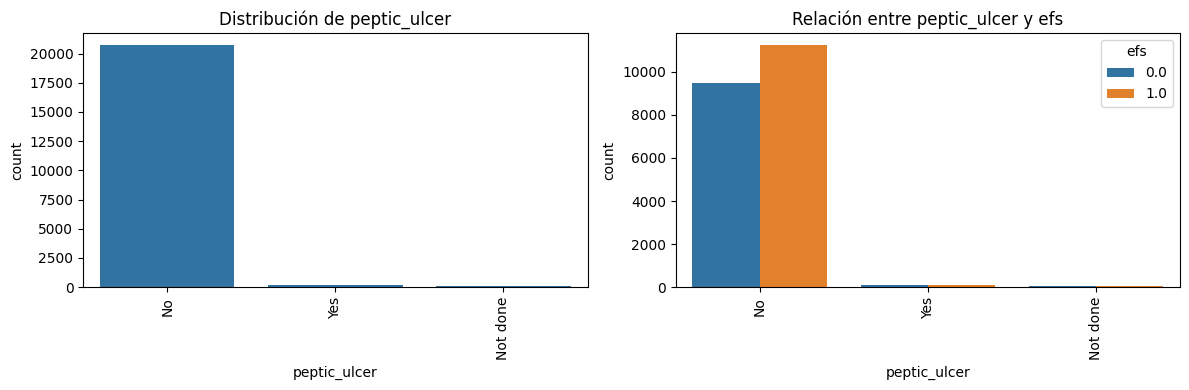

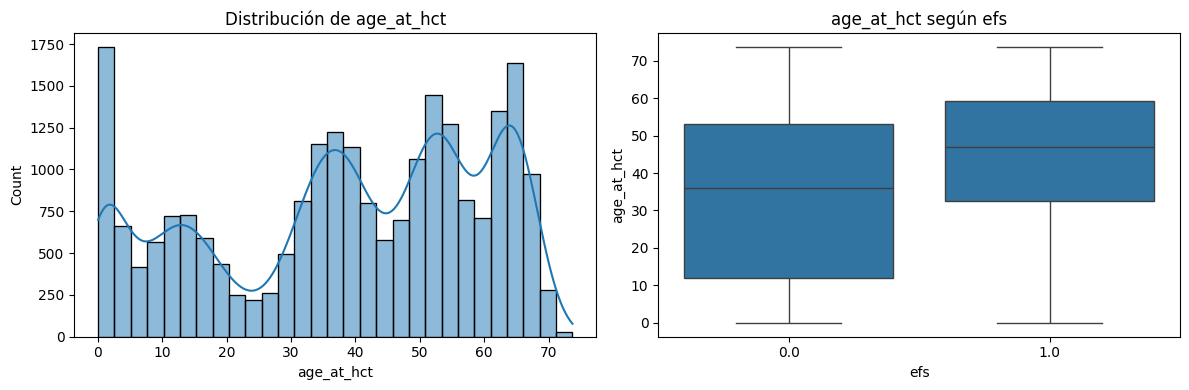

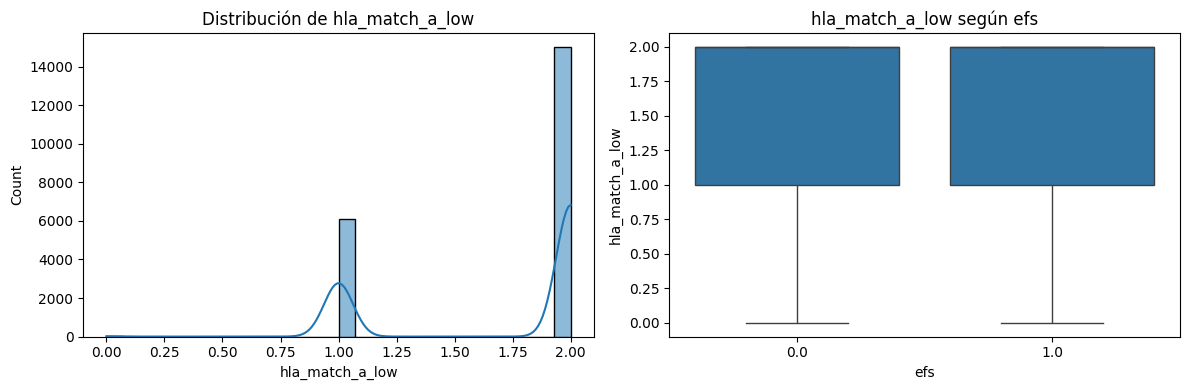

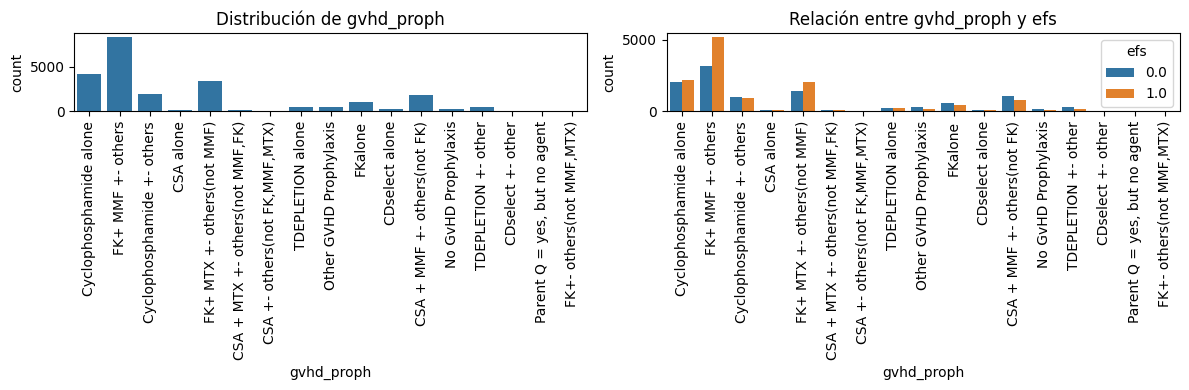

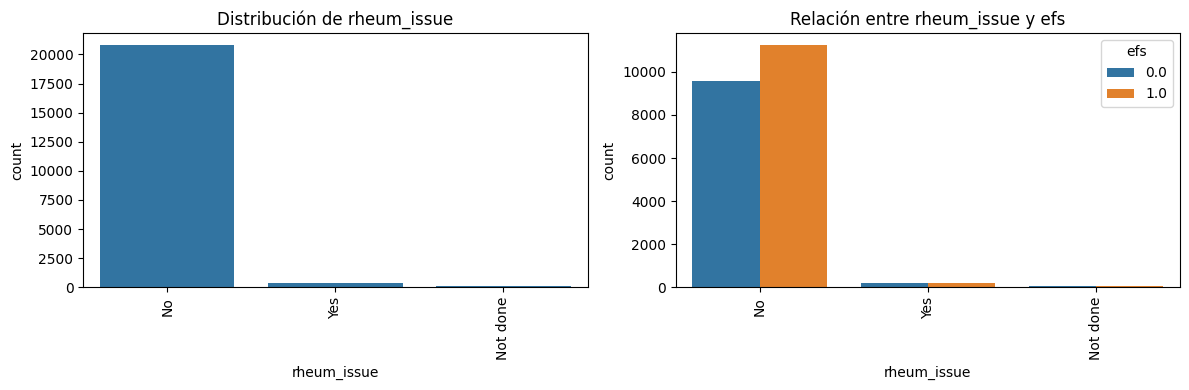

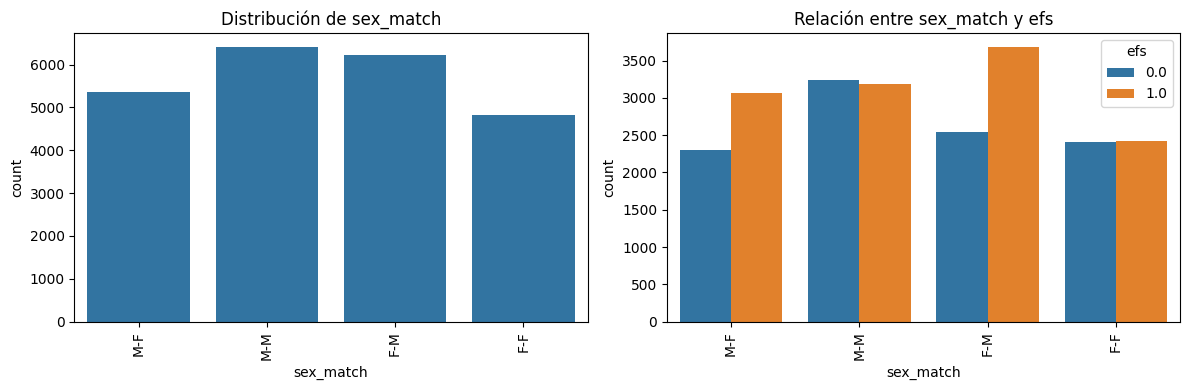

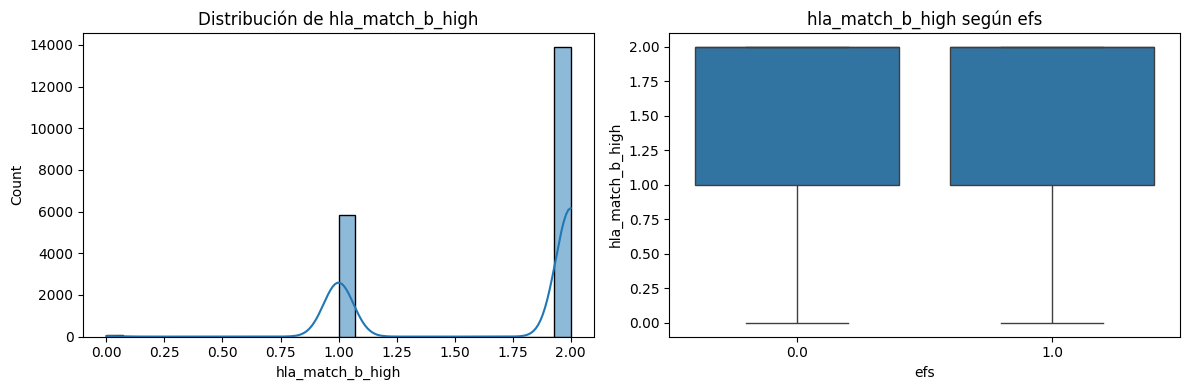

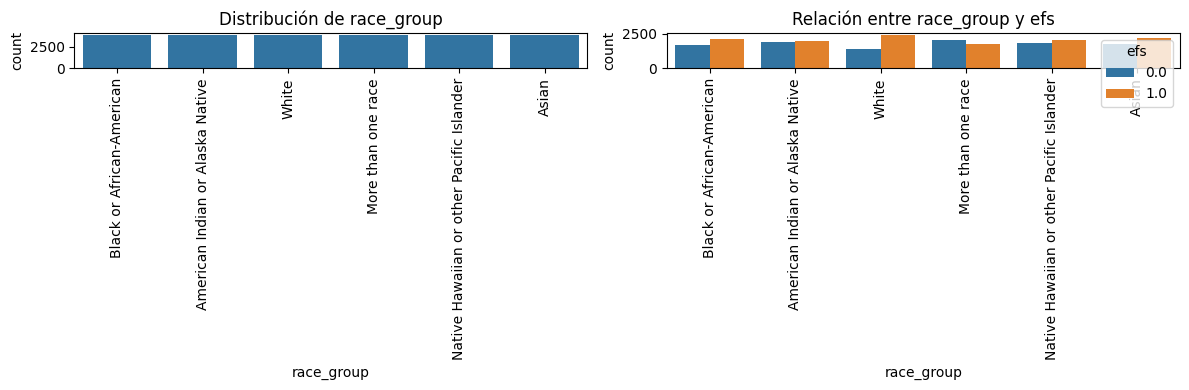

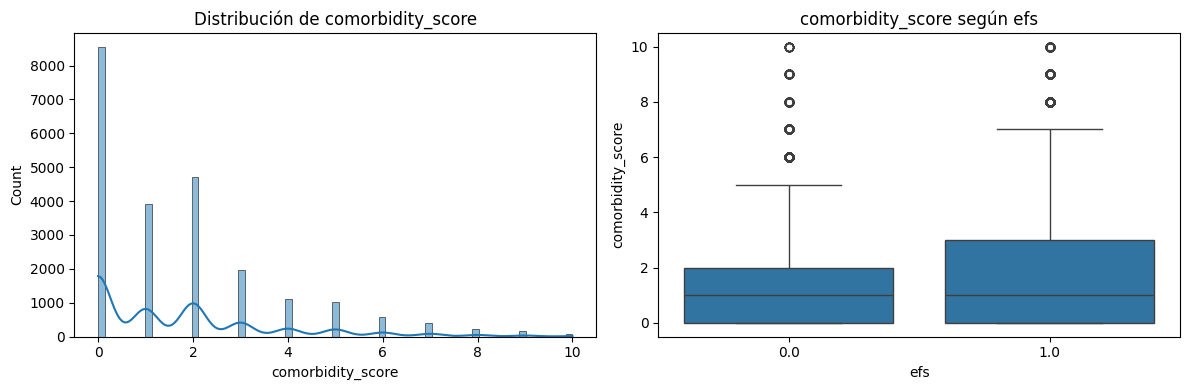

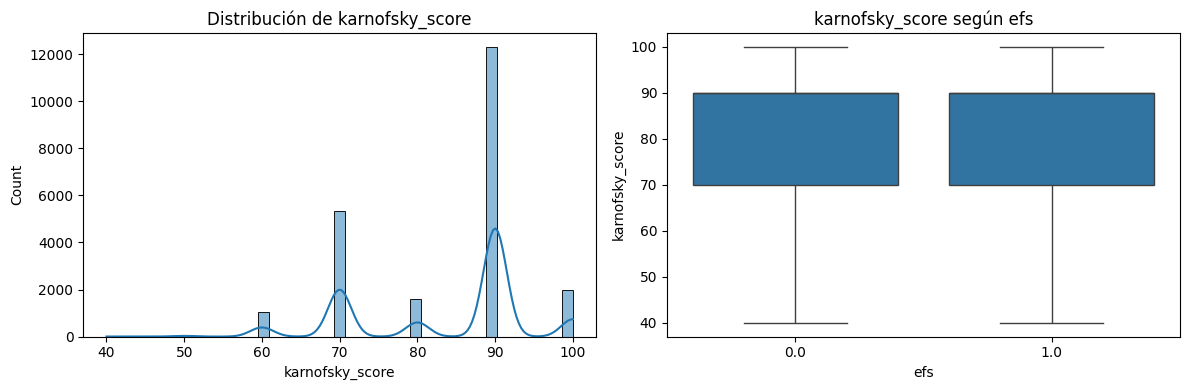

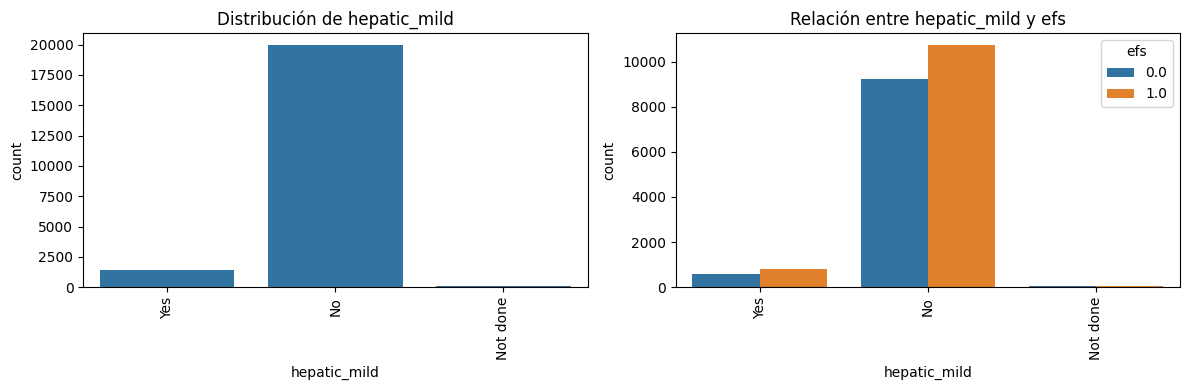

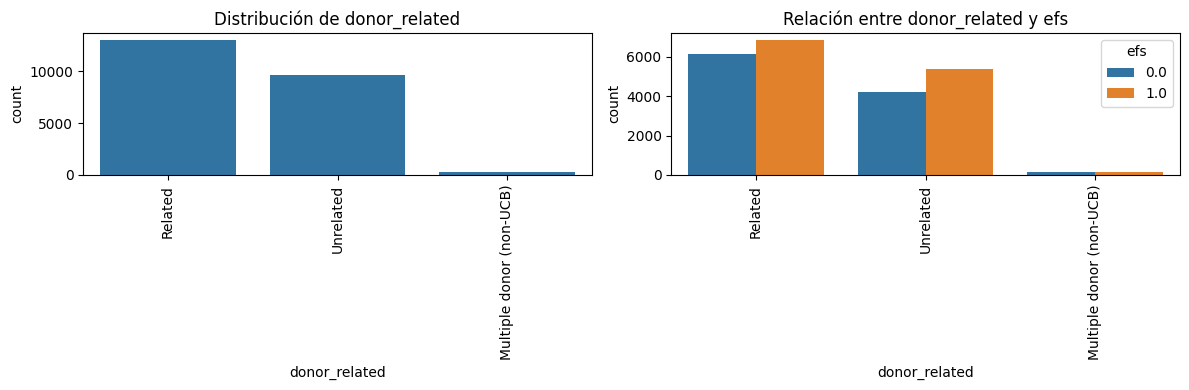

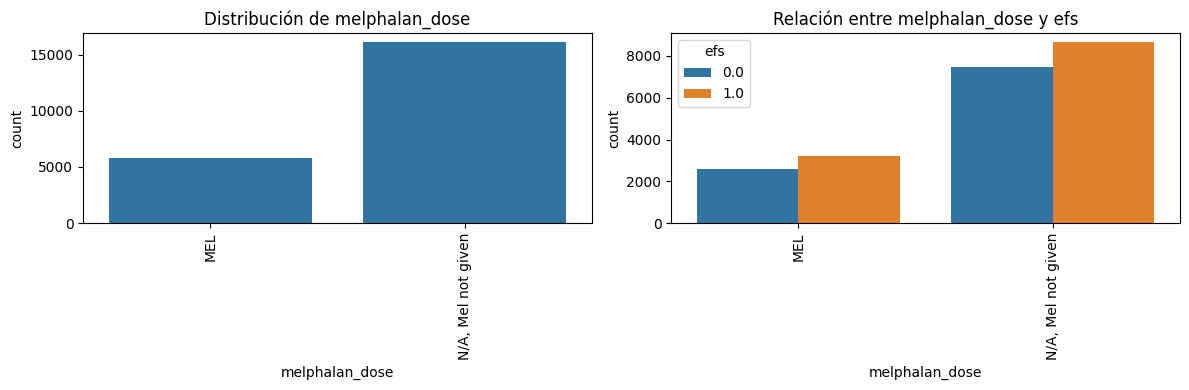

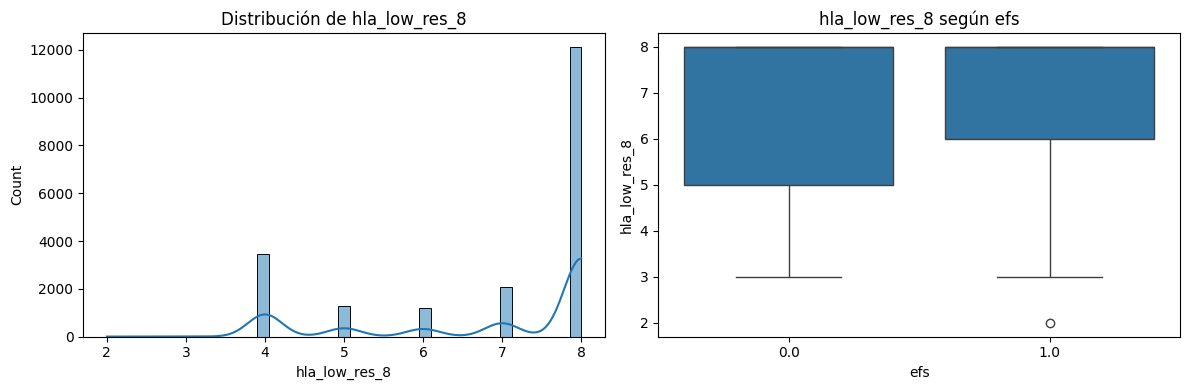

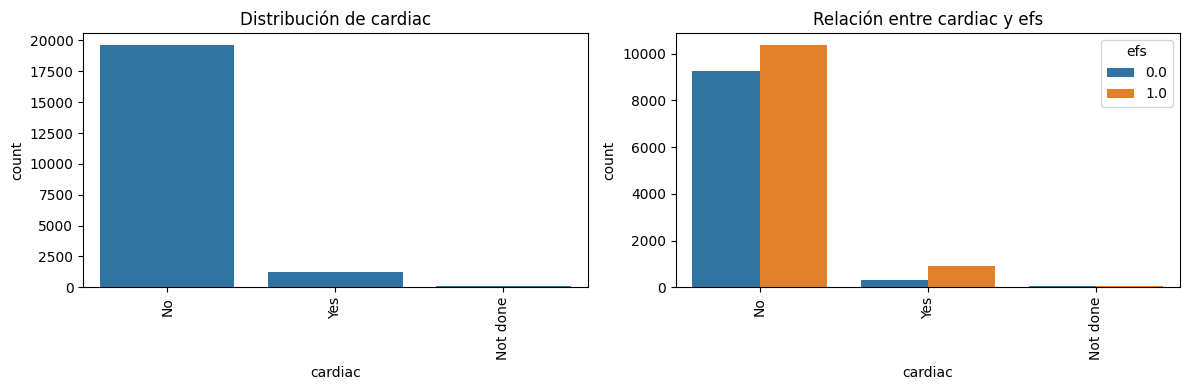

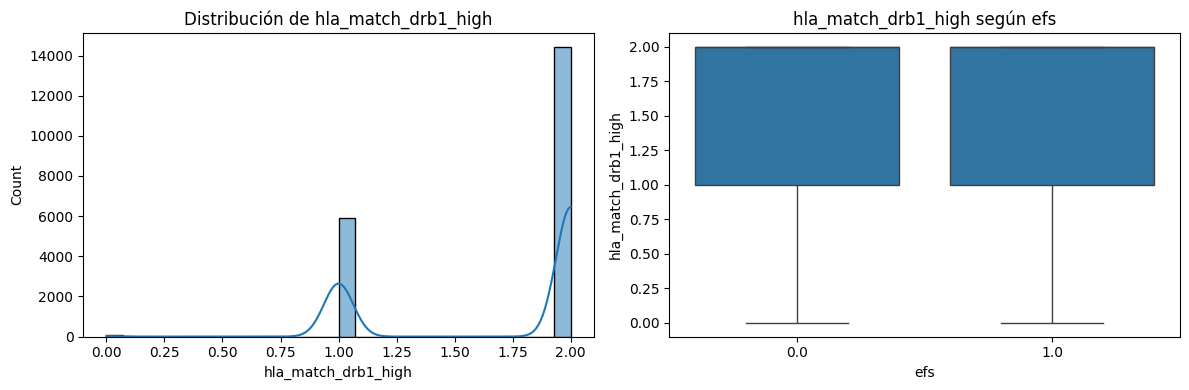

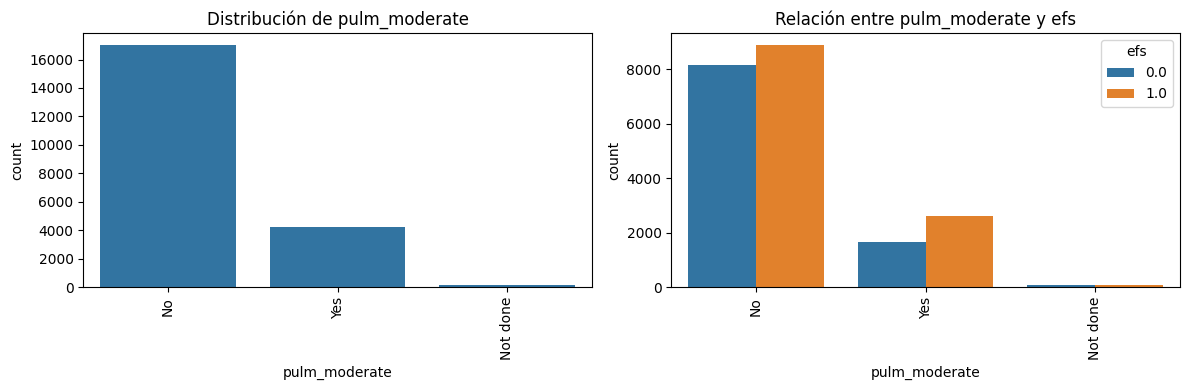

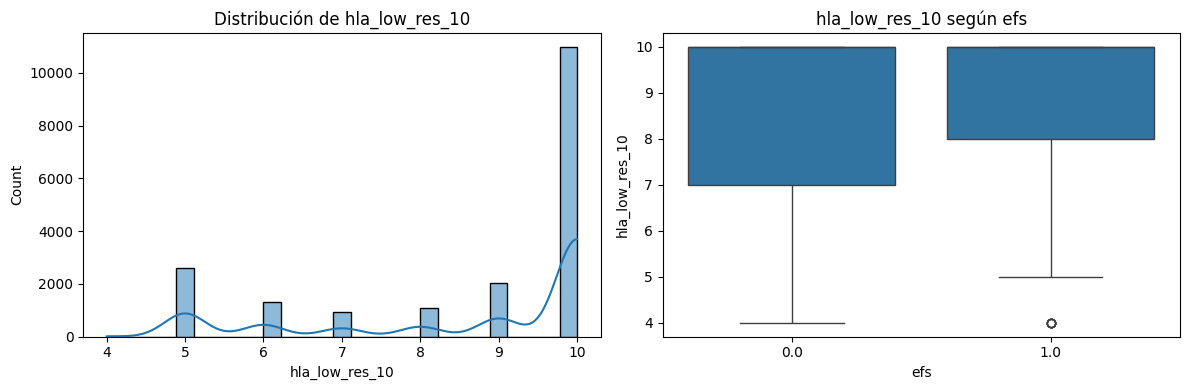

In [56]:
#Representación combinada por variable
for col in X_train.columns:
    plt.figure(figsize=(12, 4))

    #Subplot 1: Distribución de la variable
    plt.subplot(1,2,1)
    if X_train[col].dtype == 'object':
        sns.countplot(x = X_train[col])
        plt.title(f"Distribución de {col}")
        plt.xticks(rotation = 90)
    else:
        sns.histplot(X_train[col], kde = True)
        plt.title(f'Distribución de {col}')
    
    #Subplot 2: Relación con efs
    plt.subplot(1,2,2)
    if X_train[col].dtype == 'object':
        sns.countplot(data = pd.concat([X_train, y_train], axis = 1), x = col, hue = 'efs')
        plt.title(f'Relación entre {col} y efs')
        plt.xticks(rotation = 90)
    else: 
        sns.boxplot(x = y_train, y = X_train[col])
        plt.title(f'{col} según efs')

    plt.tight_layout()
    plt.show()

#### **Analizando las variables**

**Variable dri_score**

La variable **dri_score** (Disease Risk Index) representa un índice clínico que clasifica a los paciente según la gravedad o riesgo asociado a su enfermedad hematológica en el momento del trasplante de células madre hematopoyéticas (HCT). Esta clasificación permite estimar el pronóstico post-trasplante, siendo ampliamente utilizada en entornos clínicos para la toma de decisiones terapéuticas.

El conjunto de datos contiene múltiples valores categóricos para esta variable, incluyendo categorías estándar como *Low*, *Intermediate*, *High* o *Very High*, así como otras no clasificables directamente, tales como *N/A-non-malignant indication*,*N/A- non-malignant status*. Estas últimas reflejan casos donde no se disponen de una evaluación completa de la enfermedad o donde el perfil clínico no se ajusta a la escala habitual del índice.

Desde el punto de vista de la distribución, se observa que las categorías *Intermediate*, *High* y *N/A - pediatric* son las más frecuente, mientras que otras como *Very High* o *Missing disease status* están escasamente representadas. Esto sugiere una distribución altamente desbalanceada, lo que puede impactar negativamente en la capacidad del modelo para generalizar correctamente en estas clases minoritarias.

En cuanto a su relación con la variable objetivo **efs**, el análisis visual revela un patrón coherente con el significado clínico del índice: los pacientes clasificados como *High* presentan una mayor proporción de recaídas (efs = 1), mientras aquellos con *Low* o *N/A - non-malignant indication* muestran tasas más altas de supervivencia libre de eventos. Esta relación refuerza la importancia de conservar la variable, pero también sugiere que ciertas clases podrían agruparse para mejorar la estabilidad del modelo sin perder capacidad predictiva:

| Categorías originales| Nuevas categorías | 
|--------------|--------------|
| High, Very High, Hihg- TED AML case <mising cytogenetics> | High | 
| Intermediate | Intermediate |
| Low | Low |
| N/A - non-malignant indication, N/A - pediatric, N/A -disease not classificable  | N/A |
| Missing cytogenetics, TBD cytogenetics, Missing disease status  | Unknown|
| Otras no clasificables  | Other |


**Variable psych_disturb**

La varibale **psych_disturb** indicar si el paciente presenta o ha presentado antecedentes de transtornos psicológicos en el momento del transplante. 

Desde un punto de vista clínico, la presencia de alteraciones psicológicas puede influir indirectamente en la evolución del paciente post-trasplante, afectando aspectos como la adherencia al tratamiento, el seguimiento médico o incluso el estado inmunológico general, aunque su peso pronóstico es moderado en comparación con otras variables biológicas o de compatibilidad.

En el análisis exploratorio, la variable presenta un desequilibrio marcado: la gran mayoría de los pacientes está etiquetados como *No*, es decir, sin presencia de trastornos psicológicos conocidos. Un porcentaje reducido presenta la categoría *Yes*, que indica la existencia confirmada de alteraciones mentales. Por otro lado, la categoría *Not done* - que refleja la ausencia de evaluación en este aspecto - aparece con una frecuencia extremadamente baja.

La representación gráfica de la relación entre esta variable y la variable objetivo permite identificar un patrón claro: los pacientes con antecedentes de transtornos psicológicos presentan una mayor proporción de eventos adversos (es decir, recaídas, complicaciones o muerte) en comparación con aquellos que no tienen dichos antecedentes. Aunque esta diferencia no es extremadamente pronunciada, sí sugiere que **psych_disturb** podría aportar información útil al modelo de predicción de supervivencia post-trasplante. 

Desde el punto de vista del preprocesamiento, el tratamiento óptimo de esta variable requiere una simplificación que perserve su valor informativo pero que elimine el ruido estadístico derivado de clases minoritarias. Dado que la categoría *Not done* apenas tiene datos, se propone agruparla a la categoría mayoritaria (*moda*) - *No*

**Variable cyto_score**

La variable **cyto_score** representa la clasificación pronóstica citogenética del paciente, es decir, en las alteraciones cromósomicas observadas en sus células antes del trasplante de células madre hematopoyéticas (HCT). En el contexto clínico de enfermedades hematológicas, como leucemias agudas o síndromes mielodisplásicos, el estudio citogénetico es uno de los factores más relevantes para determinar el riesgo biológico de la enfermedad y la probabilidad de respuesta favorable a un trasplante. 

Los resultados de este análisis suelen clasificarse en tres grandes grupos:

* *Favorable*: anormalidades genéticas que se asocian a un buen pronóstico y alta supervivencia post-trasplante.

* *Intermediate*: anomalías de riesgo medio, con comportamiento clínico variable.

* *Poor*: alteraciones citogenéticas asociadas a mal pronóstico, alta tasa de recaída y baja supervivencia.

Junto a estas categorías principales, el conjunto de datos incluye otras como *TBD* (por determinar), *Not tested* (no se realizó el estudio), *Normal* (sin anomalías detectadas) y *Other* (posiblemente categorías no clasificadas en el sistema estándar).

En la gráfica de distribución de la variable **cyto_score** se observa que las clases *Poor*, *Intermediate* y *Favorable* son las más representadas, lo cual es consistente con el uso clínico habitual de esta escala. Las categorías *TBD*, *Normal*, *Other* y *Not tested* aparecen con menor frecuencia, lo que indica que podrían introducir ruido si se utilizan sin procesar.

La relación entre **cyto_score** y la variable de salida **efs** es muy clara y coherente desde un punto de vista médico:


* Los pacientes clasificados como *Poor* presentan una proporción significativamente más alta de eventos adversos.

* Por el contrario, *Favorable* se asocia con una mayor tasa de supervivencia libre de eventos.

* *Intermediate* se sitúa en un punto intermedio, como cabría esperar.

* Las categorías poco representadas no muestran patrones concluyentes:

    * *Normal* podía parecer, en principio, equivalente a un resultado favorable. Sin embargo, en el contexto clínico, un cariotipo normal no implica necesariamente un buen pronóstico. De hecho, cuando no se detectan alteraciones, pero la enfermedad presenta otras características desfavorables, se suele clasificar como riesgo intermedio.
    
    * *Other* agrupa resultados no categorizados según los criterios estándar. Son casos infrecuentes y su interpretación clínica no es clara. Por tanto, se va a agrupar junto la categoría *Intermediate*, ya que normalmente aquellos perfiles citogenéticos que no pueden clasificarse claramente como favorables ni adversos, se consideran de riesgo intermedio.

    * *TBD* y *Not tested* indican ausencia de información útil, ya sea porque no se realizó el análisis o porque este no ha sido clasificado aún.


| Categorías originales| Nuevas categorías | 
|--------------|--------------|
| Favorable | Favorable | 
| Intermediate | Intermediate |
| Poor | Poor |
| Normal | Intermediate |
| Other| Intermediate |
| TBD | Unknown|
| Not tested | Unknown|


**Variable diabetes**

La variable **diabetes** identifica si el paciente presentaba un diagnóstico conocido de diabetes en el momento del trasplante de células madre hematopoyéticas (HCT). Esta condición forma parte del conjunto de comorbilidades médicas que, aunque no afectan directamente a la enfermedad hematológica tratada mediante el trasplante, pueden influir negativamente en la recuperación postoperatoria, aumentar el riesgo de complicaciones infecciosas, y limitar la capacidad del organismo para responder eficazmente al tratamiento.

Desde el punto de vista clínico, la diabetes es un factor de riesgo importante en cualquier procedimiento médico complejo, ya que puede comprometer órganos vitales como el corazón, el riñón o los vasos sanguíneos, y dificultar la cicatrización o la defensa inmunológica.

En el conjunto de datos, esta variable está compuesta por tres categorías:

* *Yes*: el paciente tiene diabetes.
* *No*: no tiene diabetes.
* *Not done*: no consta si se evaluó o no.

El análisis de su distribución revela que la gran mayoría de pacientes no presenta diabetes, mientras que un grupo minoritario pero significativo sí la padece. La categoría *Not done* aparece un número muy reducido de registros, lo que sugiere que su mantenimiento como categoría independiente carece de valor estadística y podría incluso introducir el ruido en el modelo.

Al observar la relación de esta variable con la variable objetivo **efs**, se percibe que los pacientes con diabetes presentan una propoción claramente superior de eventos adversos, en comparación con aquellos que no tienen esta comorbilidad.

Dado que diabetes es una variable con significado clínico binario natural, y que el registros de *Not done* es escaso, se propone simplificarla:

| Categorías originales| Nuevas categorías | 
|--------------|--------------|
| Yes | Yes | 
| No | No |
| Not done | No |

**Variable hla_match_c_high**

La variable **hla_match_c_high** refleja el nivel de compatibilidad en alta resolución en el locus HLA-C entre el donante y el receptor del trasplante. El sistema HLA (antígeno leucocitario humano) es un componente clave en la respuesta inmunitaria, y su compatibilidad es crítica para minimizar el riesgo de rechazo, enfermedad injerto contra huésped (GVHD) y otras complicaciones inmunológicas post-trasplante.

En este caso, la variable toma valores numéricos discretos: 0,1 o 2, que indican el número de alelos coincidentes entre el donante y el receptor:

* 2: coincidencia completa en ambos alelos -> **compatibilidad total**
* 1: coincidencia parcial
* 0: sin coincidencia, es decir, incompatibilidad completa. 

El análisis de su distribución revela:

* La mayoría de los valores se concentran en torno a los extremos: 1 y 2, siendo 2 la categoría más frecuente.
* El valor 0 aparece en muy pocos casos, lo que refleja que normalmente se intenta evitar trasplantes con incompatibilidades completas.

Al observar la relación de esta variable con la variable objetivo **efs**:

* No se observa una diferenciación clara en la distribución de **hla_match_c_high** entre los grupos efs = 0  y efs = 1. Esto sugiere que esta variable podría no tener un impacto directo y significativo sobre la probabilidad de eventos adversos en este conjunto concreto, o que su efecto está diluido por otras compatibilidades HLA más relevantes.

La variable **hla_match_c_high** representa el nivel de compatibilidad en el locus HLA-C entre el donante y receptor. Aunque clínicamente tiene sentido incluirla, su distribución en el conjunto de datos está muy concentrada en la categoría de compatibilidad total, y el análisis no muestra una relación clara con el desenlace. Por ello, se ha decidido mantener inicialmente en el modelo, pero se evaluará su impacto y será eliminada si no aporta valor predictivo significativo.


**Variable hla_high_res_8**

La variable **hla_high_res_8** indica el número total de loci HLA coincidentes en alta resolución entre el donante y el receptor del trasplante. En concreto, este valor se refiere a la coincidencia en 8 loci comúnmente evaluados en los trasplantes alogénicos, y se expresa como un número entero de coincidencias: desde 0 (ninguna coincidencia) hasta 8 (coincidencia total).

Desde un punto de vista clínico, esté número es de gran relevancia, ya que una mayor coincidencia HLA se asocia directamente con una menor probabilidad de rechazo del injerto, menos enfermedad injerto contra huésped y, en general, una mayor supervivencia post-trasplante. Por tanto, esta variable es una medida sintética del grado de compatibilidad inmunológica entre donante y receptor.

El análisis de su distribución revela:

* La mayoría de los pacientes tienen valores altos de coincidencia, especialemente el valor 8, que representa compatibilidad total.

* También se observan valores intermedios entre 4 y 7, aunque con menor frecuencia.

* Los valores por debajo de 4 son poco frecuente, lo cual refleja la práctica clínica habitual de priorizar donantes altamente compatibles.

Al observar la relación de esta variable con la variable objetivo **efs**:

* La gráfica de cajas muestra que los pacientes con efs = 0 tienden a tener una media y una mediana ligeramente superiores de compatibilidad HLA que aquellos con efs = 1. 
* Aunque no hay una separación drástica, sí existe una diferencia visible.


**Variable tbi_status**

La variable **tbi_status** indica el uso y tipo de irradiación corporal total (TBI) que recibió el paciente como parte del régimen de acondicionamiento previo al trasplante de células madre hematopoyéticas (HCT). Este procedimiento se utiliza para destruir células enfermas o inmunológicas antes del injerto, y puede aplicarse solo o combinado con otros agentes quimioterápicos.

El análisis de su distribución revela:

* La categoría *No TBI* es la más frecuente con diferencia, lo cual refleja la existencia de pacientes que han recibido regímenes de acondicionamiento sin irradiación.
* El resto de categorías están muy dispersas y son poco frecuentes, cada una con un número relativamente bajo de observaciones.

Al observar la relación de esta variable con la variable objetivo **efs**:

* En general, no se aprecian diferencias muy marcadas entre las proporciones de eventos adversos (efs=1) en las distintas categorías de TBI.

La utilización de TBI puede influir tanto positiva como negativamente en los resultados del trasplante. Mientras que puede mejorar el control de la enfermedad residual, también aumenta el riesgo de toxicidad y complicaciones, dependiendo de la dosis y el tipo de administración.

Desde el punto de vista clínico, sin embargo, no siempre es posible distinguir un efecto directo entre las múltiples subcategorías si no se cuenta con información adicional detallada.

Dada la alta dispersión, la baja frecuencia de la mayoría de las categorías y el poco valor predictivo observable visualmente, se recomienda agrupar la variable en dos niveles principales:

* *No TBI*
* *TBI*

**Variable arrhytmia**

La variable **arrhytmia** indica si el paciente presentaba trastornos del ritmo cardíaco (arritmias) antes del trasplante de células madre hematopoyéticas (HCT). Las arritmias pueden ser signos de disfunción cardíaca que, aunque no se relacionan directamente con la enfermedad hematológica de base, pueden influir negativamente en la tolerancia, la estabilidad hemodinámica durante el proceso, y la probabilidad de complicaciones postoperatorias.

El análisis de su distribución revela:

* La mayoría de los pacientes se agrupan en la categoría *No*, es decir, sin arritmias documentadas.
* La categoría *Yes* tiene una frecuencia baja pero presente, lo que indica que una proporción menor de pacientes sí presenta esta comorbilidad.
* La categoría *Not done* es anecdótica, con muy pocos registros.


Al observar la relación de esta variable con la variable objetivo **efs**:

* Entre los paciente con *Yes* (arritmia), hay una ligera mayor proporción de eventos adversos (efs = 1) en comparación con los que no presentan arritmia.

* En pacientes sin arritmia, el número de pacientes con efs = 0 es ligeramente inferior el número con efs = 1, aunque la diferencia no es muy pronunciada.

* *Not done* no aporta información clara y su frecuencia es despreciable.

Desde el punto de vista clínico:

* La presencia de arritmias es una comorbilidad relevante que puede empeorar el pronóstico general, especialmente cuando se combinan otros factores de riesgo cardíaco.

* Aunque la variable está desbalanceada, su comportamiento es coherente ocn la hipótesis clínica de que los pacientes con disfunción cardíaca previa podrían tener peores resultados.

Para simplicar la variable y conservar su valor clínico, se propone una transformación:

| Categorías originales| Nuevas categorías | 
|--------------|--------------|
| Yes | Yes | 
| No | No |
| Not done | No |



**Variable hla_low_res_6**

La variable **hla_low_res_6** representa el número total de coincidencias HLA en 6 loci en principales, pero evaluadas en baja resolución (es decir, con menor detalle molecular que las pruebas de alta resolución). Esta medida proporciona una estimación de compatibilidad inmunológico entre donante y receptor, aunque con menor precisión que las versiones en alta resolución como **hla_high_res_8**

El análisis de su distribución revela:

* La mayoría de los pacientes presentan una puntuación de 6, lo que indica compatibilidad total en todos los loci considerados.
* También se observan frecuencias destacadas en valores como 3, 4 y 5, aunque son mucho menos comunes..


Al observar la relación de esta variable con la variable objetivo **efs**:

* En el boxplot no se observan diferias visuales notables entre las distribuciones **hla_low_res_6** en pacientes con efs = 0 y efs = 1.

Desde el punto de vista clínico:

* Aunque los datos HLA de baja resolución pueden ser informativos, actualmente se da prioridad a la información el alta resolución por su mayor capacidad de predicción de resultados adversos.

Desde el punto de vista del modelado:

* La ausencia de una relación clara con **efs** y su redundancia con otras variables HLA más precisas plantean dudas sobre su aportación al modelo. Por tanto, se porpone eliminar del modelo.

-----
Eliminar del modelo


**Variable graft_type**

La variable **graft_type** indica la fuente del injerto utilizado en el trasplante. Existe diferentes tipos de fuentes de células madre que pueden emplearse en un trasplante alogénico:

* Peripheral blood (sangre periférica): extracción de células madre directamente de la sangre del donante tras estimulación con factores de crecimiento.
* Bone marrow (médula ósea): extracción quirúrquica directa desde los huesos.

Cada tipo de injerto tiene implicaciones clínicas diferente:

* Peripheral blood tiende a injertar más rápido pero con mayor riesgo de enfermedad injerto contra huésped.
* Bone marrow puede ser más lenta en la recuperación, pero menor incidencia de GVHD severa.

El análisis de su distribución revela:

* La mayoría de los pacientes recibieron injertos de sangre periférica, lo que refleja una práctica común en la actualidad.

Al observar la relación de esta variable con la variable objetivo **efs**:

* Los pacientes que recibieron Bone marrow presentan una proporció mayor de supervivencia libre de eventos.
* Los pacientes con Peripheral blood muestran más casos de recaída o eventos.


**Variable vent_hist**

La variable **vent_hist** indica si el paciente ha requerido soporte respiratorio en algún momento antes del trasplante. Este dato refleja un historial clínico asociado a insuficiencia respiratoria grave o la necesidad de cuidados intensivos.

Desde el punto de vista clínico, el hecho de que un paciente haya requerido ventilación previa es un marcador de enfermedad crítica o fragilidad funcional, y suele estar relacionado con peor estado basar, mayor riesgo de infecciones y complicaciones durante el proceso de trasplante. 

El análisis de su distribución revela:

* La categoría *No* es mayoritaria, indicando que la mayoría de pacientes no presentaron antecendentes de ventilación.
* *Yes* aparece en una proporción muy baja, lo que sugiere que se trata de una subgrupo clínicamente más complejo pero poco representado.

Al observar la relación de esta variable con la variable objetivo **efs**:

* En la categoría *Yes*, se observa una proporción ligeramente mayor de eventos adversos (efs = 1) en comparación con los pacientes sin ventilación. 


**Variable renal_issue**

La variable **renal_issue** indica si el paciente presentaba problemas renales previos al trasplante de células madre hematopoyéticas (HCT). Las disfunciones renales pueden derivarse de enfermedades crónicos, toxicidad previa por tratamientos, o estados críticos que afectan la perfusión renal.

Clínicamente, esta información es muy relevante, ya que la presencia de alteraciones en la función renal afecta la tolerancia a la quimioterapia de acondicionamiento, aumenta el riesgo de toxicidad, y puede complicar el manejo post-trasplante. Además, es un componente habitual de los índices de comorbilidad pre-trasplante.

El análisis de su distribución revela:

* La categoría *No* es mayoritaria.
* *Yes* aparece en una proporción muy baja, lo que sugiere una representación limitada de pacientes con problemas renales conocidos.

Al observar la relación de esta variable con la variable objetivo **efs**:

* Los pacientes con *Yes* parecen presentar una proporción ligeramente más alta de eventos adversos (efs=1), aunque el tamaño muestral es muy pequeño.
* *No* tiene una distribución equilibrada entre eventos y no eventos.
* *Not done* no aporta información debido a su baja frecuencia.

| Categorías originales| Nuevas categorías | 
|--------------|--------------|
| Yes | Yes | 
| No | No |
| Not done | No |



**Variable pulm_severe**

La variable **pulm_severe** identifica si el paciente presenta enfermedad pulmonar severa antes del transplante de céluslas madre hematopoyéticas (HCT). Este tipo de afectación puede incluir disfunción respiratoria grave, alteraciones estructurales pulmonares o dependencia de oxígeno, entre otras.

Desde el punto de vista clínico, la función pulmonar previa al trasplante es un factor pronóstico relevante, ya que una capacidad respiratoria comprometida aumenta el riesgo de complicaciones respiratorias post-trasplante, infecciones y toxicidad derivada del acondicionamiento.

El análisis de su distribución revela:

* La categoría *No* predomina de forma clara, lo cual es habitual, ya que la mayoría de los pacientes seleccionados para trasplante suelen estar clínicamente estables.
* *Yes* aparece en una proporción muy baja, pero significativa.
* *Not done* es prácticamente inexistente.

Al observar la relación de esta variable con la variable objetivo **efs**:

* Los pacientes con *Yes* muestran una mayor proporción de eventos adversos que aquello sin enfermedad pulmonar.
* *No* tiene una distribución equilibrada entre eventos y no eventos.
* *Not done* no aporta información debido a su baja frecuencia.

| Categorías originales| Nuevas categorías | 
|--------------|--------------|
| Yes | Yes | 
| No | No |
| Not done | No |



**Variable prim_disease_hct**

La variable **prim_disease_hct** identifica la enfermedad primaria por la que se ha indicado el trasplante de células madre hematopoyéticas (HCT). Es, por tanto, una de las variables más determinantes desde el punto de vista clínico, ya que el tipo y la agresividad de la enfermedad de base influye directamente en el riesgo de recaída, la elección del régimen de acondicionamiento y la probabilidad de éxito del trasplante.

Entre las enfermedades más representadas en el dataset se encuentran:

* AML (leucemia mieloide aguda)
* ALL (leucemia linfoblástica aguda)
* MPN (neoplasias mieloproliferativas)
* MDS (síndromes mielodisplásicos)

El análisis de su distribución revela:

* AML, ALL y MPN son las enfermedades más frecuentes en el conjunto de datos, lo que refleja su prevalencia como indicadores de trasplante.
* Existen múltiples categorías con baja representación individual, que podrían generar ruido si se codifican tal cual.

Al observar la relación de esta variable con la variable objetivo **efs**:

* Se observan diferencias visibles en la distribución de eventos según el tipo de enfermedad:

    * ALL y AML presentan una proporción alta de recaídas (efs=1), lo cual es clínicamente esperable dada su agresividad.
    * Enfermedades como AI o solid tumors parecen estar asociadas a menos eventos, qunque su bajo número hace que las conclusiones sean débiles.

* Hay categorías muy poco frecuentes que no aportan valor individualmente.

La variable **prim_disease_hct**, que representa la enfermedad primaria del paciente al momento del trasplante, fue transformada para reducir el número de categorías. En lugar de seleccionar manualmente las categorías a conservar, se aplicó un criterio objetivo: se van a mantener todas las enfermedades con al menos 1000 registros en el conjunto de entrenamiento, mientras que el resto serán agrupadas en la categoría *Other_disease*.


| Categorías originales| Nuevas categorías | 
|--------------|--------------|
| AML, ALL, MPN, MDS, IPA, PCD ... | Se mantienen aquellas categorías con más de 1000 registros| 
| Resto | Other |




**Variable hla_high_res_6**

La variable **hla_high_res_6** representa el número total de coincidencias HLA en alta resolución en 6 loci estándar, medido con técnicas moleculares más precisas que las de baja resolución. Esta medida cuantifica el grado de compatibilidad inmunológica entre el donante y el receptor antes del trasplante.

Desde el punto de vista clínico, un mayor número de coincidencias se asocia con un menor riesgo de rechazo, menor incidencia de enfermedad injerto contra huésped, y generalmente mejores tasas de supervivencia tras el trasplante. 

El análisis de su distribución revela:

* La mayoría de los pacientes tienen compatibilidad completa.
* También se observan frecuencias en 3, 4, 5, aunque en menor proporción.

Al observar la relación de esta variable con la variable objetivo **efs**:

* No se observa una diferencia evidente entre los valores de **hla_high_res_6** entre pacientes que presentan efectoa y aquellos que no.

Por su valor clínico, se va a mantener inicialmente en el modelo.




**Variable cmv_status**

La variable **cmv_status** representa el estado serológico del paciente y del donante frente al virus citomegalovirus (CMV), una infección viral latente que puede reactivarse en pacientes inmunocomprometidos, como los receptores de un trasplante de células madre hematopoyéticas.

Las combinaciones posibles de estado serológico entre receptor y donante son:

* +/+: tanto paciente como donante son seropositivos (exposición previa al virus).
* +/-: el paciente es positivo y el donante negativo.
* -/+: el paciente es negativo y el donante positivo.
* -/-: ambos son seronegativos.

El estado serológico frente al CMV afecta directamente al riesgo de reactivación del virus tras el trasplante, siendo especialmente arriesgado el caso en que el receptor es negativo y el donante es positivo, ya que puede implicar una primoinfección post-trasplante más difícil de controlar.

El análisis de su distribución revela:

* La combinación *+/+* es la más frecuente, lo cual es esperable ya que el CMV es muy común en adultos.
* Las combinaciones mixtas y *-/-* también están presentes en proporciones razonables, lo que permite su análisis sin necesidad de agrupación inmediata.

Al observar la relación de esta variable con la variable objetivo **efs**:

* El grupo *+/+* tiene una proporción ligeramente más alta de eventos adversos.
*  El grupo *+/-* muestra una tendencia parecida, pero ligeramente menos desfavorable. 
*  El grupo *-/+* es el de mayor riesgo clínico teórico, aunque visualmente en este conjunto los resultados no son tan diferentes.
*  El grupo *-/-* parece tener mejores resultados, aunque la diferencia no es muy marcada.

En este caso, y debido a la base clínica, se van a mantener las cuatro categorías.



**Variable hla_high_res_10**

La variable **hla_high_res_10** representa el número de coincidencias HLA en alta resolución entre donante y receptor en un total de 10 loci. Es una medida extendida de compatibilidad que incorpora no solo los loci clásicos, sino también otros como DPB1 o variantes adicionales, proporcionando una visión más completa de la compatibilidad inmunológica. 

Cuanto mayor es este valor, mayor es la compatibilidad global entre el donante y el receptor, lo que clínicamente se asocia con menor riesgo de rechazo, menor incidencia de GVHD y mejor pronóstico post-trasplante.

El análisis de su distribución revela:

* El valor 10 es el más frecuente, lo cual sigiere que se prioriza esta condición durante la asignación de donantes.

Al observar la relación de esta variable con la variable objetivo **efs**:

* El boxplot muestra que los pacientes que no presentaron eventos adversos tienden a tener una compatibilidad ligeramente superior (mayor mediana) respecto a quienes sí los presentaron.

----

MANTENER VARIABLE




**Variable hla_match_dqb1_high**

La variable **hla_match_dqb1_high** representa el nivel de coincidencia HLA en el locus DQB1, evaluado en alta resolución. Este locus forma parte del complejo mayor de histocompatibilidad de clase II, y su coincidencia entre el donante y el receptor es relevante para reducir el riesgo de complicaciones inmunológicas, como la enfermedad injerto contra huésped (GVHD) y el rechazo del injeto.

Los valores observados indican el número de alelos coincidentes:

* 0: sin coincidencia.
* 1: coincidencia parcial.
* 2: coincidencia total.

El análisis de su distribución revela:

* Hay un claro predominio de los valores 2 (coincidencia completa) y 1(coincidencia parcial).
* El valor 0 aparece muy raramente, lo que es esperable porque una falta total de coincidencia en DQB1 se intenta evitar clínicamente al seleccionar variables.

Al observar la relación de esta variable con la variable objetivo **efs**:

* El boxplot muestra que no hay una diferencia muy marcada entre los grupos efs = 0 y efs = 1.

----

MANTENER VARIABLE

**Variable hla_nmdp_6**

La variable **hla_nmdp_6** representa el número de coincidencias HLA en 6 loci según los estándares del National Marrow Donor Program. Esta puntuación se basa en una clasificación valida clínicamente para evaluar la compatibilidad entre donante y receptor. 

Una puntuación de 6 indica una coincidencia completa; valores inferiores reflejan mayor grado de incompatibilidad.

El análisis de su distribución revela:

* La gran mayoría de los pacientes tiene puntuación 6, es decir, compatibilidad completa. 

Al observar la relación de esta variable con la variable objetivo **efs**:

* El boxplot muestra que los pacientes con efs = 0 tienden a tener una compatibilidad ligeramente menor que los que recaen. Esto no lo clínicamente esperado. Sin embargo, esta diferencia es pequeña y no concluyente visualmente.

Este comportamiento puede deberse a múltiples factores:

* El impacto de hla_nmdp_6 puede estar modulado por otros factores, como tipo de enfermedad, régimen de acondicionamiento o tipo de donante.
* Puede haber un efecto inverso si los pacientes con peor compatibilidad fueron seleccionados por otras razones clínicas.

----

MANTENER VARIABLE


**Variable hla_match_c_low**

La variable **hla_match_c_low** indica el número de alelos coincidentes entre donante y receptor en el locus HLA-C, evaluado en baja resolución. Esta medida refleja el grado de compatibilidad inmunológica en ese locus específico, aunque con menor detalle que su contraparte en alta resolución.

Los valores posibles son:
* 0: sin coincidencia.
* 1: coincidencia parcial.
* 2: coincidencia total.

El análisis de su distribución revela:

* La mayoría de los paciente tiene valor 2, lo que indica compatibilidad total en este locus.

Al observar la relación de esta variable con la variable objetivo **efs**:

* El boxplot muestra una concetración casi total en el valor 2 para ambos grupos. 
* No se observan diferencias notables entre los grupos, lo que sugiere que la variabilidad de esta variable es baja y su valor predictivo por si sola puede ser limitado.

----

ELIMINAR VARIABLE


**Variable rituximab**

La variable **rituximab** indica si el paciente recibió Rituximab como parte del régimen de tratamiento o acondicionamiento previo al trasplante. Rituximab es un anticuerpo, comúnmente utilizado en el tratamiento de linfomas B, leucemias linfocíticas y algunas enfermedades autoinmunes.

Su administración puede estar asociada a :

* Reducción de la carga tumoral antes del trasplante.
* Disminución del riesgo GVHD en algunos protocolos. 
* En cierto contextos, donde hay mayor riesgo de infecciones post-trasplante, debido a inmunosupresión prolongada.

El análisis de su distribución revela:

* La mayoría de los pacientes no recibieron Rituximab (clases desbalanceadas).

Al observar la relación de esta variable con la variable objetivo **efs**:

* En ambos grupos, hay una ligera mayor proporción de eventos adversos.
* Sin embargo, dado el número tan bajo de pacientes con *Yes*, no es posible sacar conclusiones claras visualmente.

---

Incluirla en el modelo inicial, por su relevancia clínica. 
Evaluar su importancia tras el entrenamiento. Si no aporta valor o introduce inestabilidad, puede eliminarse o combinarse con otras variables relacionadas con tipo de enfermedad (**prim_disease_hct**) o tratamiento (**conditioning_intensity**)

**Variable hla_match_drb1_low**

La variable **hla_match_drb1_low** representa el nivel de coincidencia HLA en el locus DRB1, pero evaluado en baja resolución. El locus DRB1 es uno de los más importantes en la histocompatibilidad para trasplantes, especialemente porqu está fuertemente implicado en la presentación antigénica y, por tanto, en el riesgo de enfermedad injerto contra huésped.

Los valores posibles suelen ser:
* 1: coincidencia parcial.
* 2: coincidencia total.

El análisis de su distribución revela:

* Hay una clara predominancia del valor 2, lo que indica que la mayoría de los pacientes tienen coincidencia completa en DRB1, al menos a baja resolución.

Al observar la relación de esta variable con la variable objetivo **efs**:

* En el gráfico de cajas se observa que ambos grupos están completamente concentrados en los valores 1 y 2, sin ninguna diferenciación aparente. 
* El patrón es tan estable que los dos grupos se solapan completamente, indicado que esta variable, por sí sola, no permite distinguir entre pacientes con o sin eventos adversos.

----

ELIMINAR VARIABLE

**Variable hla_match_dqb1_low**

Esta variable indica el nivel de coincidencia en el locus HLA-DQB1 entre el donante y receptor, evaluado en baja resolución. Como parte del complejo mayor de histocompatibilidad, este locus es relevante para la activación del sistema inmune. La coincidencia en DQB1 contribuye a reducir el riesgo de complicaciones post-trasplante, aunque tiene menos peso clínico que DRB1.

Los valores típicos son:

* 0: sin coincidencia.
* 1: coincidencia parcial.
* 2: coincidencia total.

El análisis de su distribución:

* La mayoría de los pacientes tienen valor 2 -> coincidencia total.

Al observar la relación de esta variable con la variable objetivo **efs**:

* En el boxplot, tanto el grupo con efs = 0 como en efs = 1 están casi exclusivamente en el valor 2.
* Los outliers (valores 0 y 1) están distribuidos en ambos grupos sin una tendencia clara.
* Por tanto, no se observa una separación visual evidente entre los grupos según el valor de esta variable.

Aunque la coincidecia en DQB1 puede influir en la tolerancia inmunológica, esta variable en baja resolución y con poca variabilidad tiene valor predictivo limitado por sí sola. Su aporte puede quedar solapado por otras variables HLA más determinantes o por su versión en alta resolución, por tanto, se va a eliminar del modelo.

----
Eliminar variable

**Variable prod_type**

La variable **prod_type** hace referencia al tipo de producto de células madre utilizado para el trasplante. Esta información está estrechamente relacionada con la variable **graft_type**, aunque no siempre exactamente equivalentes en distintos datasets. Aquí los valores son:

* BM: Bone Marrow (médula ósea).
* PB: Peripheral Blood (sangre periférica).

Estos dos tipos de fuente celular tienen diferencias clínicas importantes:

* BM:
    * Mayor tolerancia inmunológica.
    * Menor riesgo de enfermedad injerto contra huésped.
    * Recuperación hematopoyética algo más lenta.
* PB:
    * Injerto más rápido.
    * Mayor riesgo de GVHD, pero puede estar indicado por características de la enfermedad o urgencia.

El análisis de su distribución revela:

* La mayoría de los pacientes recibió productos obtenidos por sangre periférica, lo cual refleja las prácticas clínicas actuales por su disponibilidad y rapidez de injerto.

* Un número considerable recibió médula ósea (BM), lo cual asegura representatividad para el análisis.

Al observar la relación de esta variable con la variable objetivo, **efs**:

* PB muestra una proporción claramente mayor de eventos adversos.
* BM se asocia con más pacientes sin eventos en relación con su tamaño de grupo.
* Este patrón es coherente clínicamente con la mayor incidencia de GVHD asociada al uso de sangre periférica.

---
Mantener variable

**Variable conditioning_intensity**

La variable **conditioning_intensity** describe la intensidad del régimen de acondicionamiento que se administra antes del trasplante. Este régimen se compone generalmente de quimioterapia, radioterapia o ambas, y su objetivo es:

* Erradicar la enfermedad residual.
* Suprimir el sistema inmunológico para evitar rechazo.
* Crear espacio para el injerto.

Los valores típicos incluyen:

* *MAC* (Myeloablative Conditioning): alta intensidad, más tóxico per con mayor efecto antitumoral.
* *RIC* (Reduced Intensity Conditioning): intensidad moderada.
* *NMA* (Non-Myeloablative): intensidad muy baja, indicada para pacientes frágiles.
* *TBD*, *No drugs reported* o *N/A...*: categoría sin datos claros o no informadas.

La distribución de la variable revela:

* *MAC* es el régimen más común, seguida por *RIC* y *NMA*.
* Las categoría restantes tienen frecuencias muy bajas.

Al observar la relación de esta variable con la variable objetivo:

* *MAC* y *RIC* presentan una proporción alta de eventos adversos.
* *NMA* parece ligeramente menos asociado a eventos, auqneu esto también puede deberse al tipo de pacientes tratados.

Para el entrenamiento del modelo, se propone hacer una agrupación de las categorías:

| Categorías originales| Nuevas categorías | 
|--------------|--------------|
| MAC, RIC, NMA | Se mantienen estas categorías| 
| TBD, No drugs reported, N/A... | Unknown |


**Variable ethnicity**

La variable **ethnicity** refleja la identidad étnica del paciente.

La distribución de la variable revela:

* La mayoría de los pacientes está etiquetados como *Not Hispanic or Latino*, lo que es esperable si los datos provienen principalmente de EEUU.
* *Hispanic or Latino** representa una minoría considerable.
* *Non-resident of U.S.* es un grupo muy pequeñp.

Al observar la relación de esta variable con la variable objetivo:

* *Not Hispanic or Latino* muestra una mayor proporción de eventos adversos en comparación con casos sin eventos.

* *Hispanic or Latino* presenta una distribución más equilibrada entre eventos y no eventos.

* *Non-resident of U.S* tiene muy pocos casos, por lo que no se puede establecer una tendencia clara.

Las diferencias observadas deben interpretarse con precaución, ya que esta variable puede reflejar desigualdades sociales, acceso al sistema sanitario o sesgos no controlados en el dataset.

Aunque la etnicidad por sí sola no debería influir biológicamente en el trasplante, puede reflejar factores sociales, económicos o de acceso que sí afectan indirectamente los resultados.  Tiene un uso potencial si el objetivo del modelo incluye el análisis de equidad o sesgos sistématicos.

---
Mantener variable



**Variable year_hct**

La variable **year_hct** representa el año en que se realizó el trasplante de células madre hematopoyéticas (HCT). Esta variable es temporal y puede reflejar:

* Evolución en las prácticas clínicas y tratamientos disponibles.
* Calidad de los datos o mejoras en los protocolos.
* Disponibilidad de medicamentos, compatibilidad HLA, etc.

La distribución de la variable refleja:

* Hay una tendencia creciente en el número de trasplantes a partir de 2013, alcanzando un pico en 2018. 

Analizando la relación entre esta variable y la variable objetivo:

* El boxplot muestra una distribución bastante simétrica entre ambos grupos. Por tanto, no se observa una diferencia clara, pero podría usarse para captar alguna tendencia sutil en modelos no lineales. 

---
Mantener variable

**Variable obesity**

La variable **obesity** indica si el paciente presentaba obesidad antes del trasplante de células madre hematopoyéticas. La obesidad es una comorbilidad importante, ya que puede influir en:

* La toxicidad del régimen de acondicionamiento.
* La farmacocinética de los inmunosupresores y quimioterapia.
* La incidencia de complicaciones postoperatorias e infecciones.

La distribución de la variable refleja:

* La gran mayoría de los pacientes no tienen obesidad.

Analizando la relación entre estas variables y la variable objetivo:

* Ambos grupos (*Yes* y *No*) muestran una mayor proporción de eventos adversos respecto a no eventos.

La obesidad tiene un valor clínico como comorbilidad, aunque su efecto directo puede estar modulado por edad, intensidad de acondicionamiento, tipo de enfermedad, etc. 

Se va a mantener, en un principio, en el modelo. Pero se va a realizar una transformación:

| Categorías originales| Nuevas categorías | 
|--------------|--------------|
|Yes |Yes| 
| No | No |
| Not done | No |


**Variable in_vivo_tcd**

La variable **in_vivo_tcd** indica si el paciente recibió depleción de células T in vivo, una técnica utilizada para reducir el riesgo de enfermedad injerto contra huésped (GVHD). Este procedimiento suele implicar el uso de fármacos como antitimocitos (ATG) o alemtuzumab antes o durante el trasplante.

La T-cell depletion (TCD) busca eliminar o reducir los linfocitos T del injerto, que son los principales responsables de reacciones inmunológicas post-trasplante.

La distribución de la variable refleja:

* A la mayoría de los pacientes no se les aplicó esta técnica, pero la proporción de los pacientes que sí la recibieron es significativa.

Analizanzo la relación entre esta variable y la variable objetivo:

* Los pacientes que no recibieron la TCD presentan una mayor proporción de eventos adversos.
* Por el contrario, entre los que sí recibieron TCD, hay una mayor proporción de pacientes sin eventos.

----
Mantener variable



**Variale hla_match_a_high**

Esta variable representa el número de alelos coincidentes entre donante y receptor en el locus HLA-A, evaluado en alta resolución. Este es uno de los loci más relevantes del complejo mayor de histocompatibilidad (MHC) clase I, fundamental para la presentación de antígenos y la activación de linfocitos T.

Los valores posibles son:

* 0: sin coincidencia.
* 1: coincidencia parcial.
* 2: coincidencia completa.

La distribución de la variable refleja:

* El valor más frecuenta con diferencia es 2, lo cual refleja una alta proporción de compatibilidad completa en este locus.

Analizando la relación entre esta variable y la variable objetivo:

* El boxplot muestra poco variabilidad entre los grupos efs = 0 y efs = 1. 

Debido al alto valor clínico, tiene sentido mantener esta variable, especialmente si se quiere evaluar la influencia acumulada de coincidencias HLA.

---
Mantener variable

**Variable hepatic_severe**

Esta variable indica si el paciente presenta enfermedad hepática severa antes del trasplante, lo cual es clínicamente muy relevante, ya que el hígado:

* participa en el metabolismo y eliminación de los fármacos.
* es un órgano vulnerable durante el trasplante debido al riesgo de toxicidad.

La distribución de la variable refleja:

* La mayoría de los pacientes está en la categoría *No*, es decir, sin afectación hepática severa. Mientras que, los pacientes con afectación representan una proporción pequeña pero visible.

Analizando la relación entre la variable estudiada y la varible objetivo:

* La mayoría de los eventos se dan el el grupo *No*, pero la categoría *Yes* muestra una ligera mayor proporción de eventos adversos en relación a su tamaño, lo que puede ser clínicamente significativo.

| Categorías originales| Nuevas categorías | 
|--------------|--------------|
|Yes |Yes| 
| No | No |
| Not done | No |


**Variable donor_age**

Esta variable representa la edad del donante en el momento del trasplante de células. Es una variable númerica continua, y tiene relevancia clínica reconocida: múltiples estudios han mostrado que una menor edad del donante se asocia a mejores resultados post-trasplante.

La distribución de la variable refleja:

* La mayoría de los donantes tienen entre 20 y 60 años.
* Se observa un pico en torno a los 25-30 años, que coincide con el perfil más común de donantes voluntarios.

Analizando la relación entre la variable estudiada y la variable objetivo:

* El boxplot muestra que los pacientes con efs = 0 tienen, en general, donantes ligeramente más jóvenes. La diferencia no es muy marcada, pero estadísticamente es coherente con la evidencia clínica.

----
Mantener variable

**Variable prior_tumor**

Esta variable indica si el paciente había sido diagnosticado con un tumor previo al trasplante, distinto de la enfermedad que motivó el HCT. Puede incluir tumores sólidos o hematológicos previos tratados y controlados.

Desde el punto de vista clínico, tener un historial de tumor previo puede influir en:

* La elegibilidad y el riesgo global del trasplante.
* La toxicidad acumulada por tratamiento previos.
* La vulnerabilidad a recaídas o segundas neoplasias.

La distribución de la variable refleja:

* La mayoría de los pancientes no tienen antecedente de tumor. Mientras que, una proporción menor pero significativa tiene historial de tumor.

Analizando la relación entre la variable estudiada y la variable objetivo:

* En ambos grupos hay más eventos adversos que casos sin evento. La proporción de eventos parece más alta en pacientes que han sido diagnosticados con tumor.

| Categorías originales| Nuevas categorías | 
|--------------|--------------|
|Yes |Yes| 
| No | No |
| Not done | No |


**Variable hla_match_b_low**

Esta variable representa el número de alelos coincidentes entre donante y receptor en el locus HLA-B, evaluado en baja resolución. HLA-B forma parte del sistema MHC de clase I y está implicado directamente en la presentación de antígenos a linfocitos T. Es un locus muy polimórfico y uno de los más relevantes en la compatibilidad HLA.

Los valores posibles son:

* 0: sin coincidencia.
* 1: coincidencia parcial.
* 2: coincidencia completa.

La distribución de la variable refleja:

* La mayoría de los pacientes tienen valor 2, lo que indica alta compatibilidad HLA-B. Se observan frecuencias menores en 1, y un número reducido en 0.

Analizando la relación entre la variable estudiada y la variable objetivo:

* El boxplot muestra una concentración clara en el valor 2 para ambos grupos.
* No se observan diferencias significativas entre los grupos: los rangos, medianas y bigotes son prácticamente idénticos. Por tanto, la variable no parece mostrar un efecto sobre el desenlace. 

El valor informativo de la variable **hla_match_b_low** se ve limitado por la disponibilidad de una variable equivalente con mayor precisión, que evalúa la misma compatibilidad pero en alta resolución molecular.

---
Eliminar variable

**Variable peptic_ulcer**

Esta variable indica si el paciente presentaba antecedentes de úlcera péptica antes del trasplante. Las úlceras pépticas pueden ser un marcador de comorbilidad gastrointestinal crónica, potencialmente asociada a:
*   Uso prolongado de antiinflamatorios o esteroides.
*   Complicaciones digestivas.
*   Mayor fragilidad del paciente ante tratamiento inmunosupresores.

La distribución de la variable refleja:
*   La gran mayoría de los pacientes están en la categoría *No*.
*   *Yes* aparece con muy baja frecuencia, lo que limita su poder discriminativo.
*   *Not done* es prácticamente inexistente.

En cuanto a la relación de esta variable con la variable objetivo:
*   La proporción de eventos adversos es más alta en el grupo *No*, pero está sesgado por el tamaño de ese grupo.
*   En general, no se observa una relación visual significativa entre la presencia de úlcera y el desenlace.

----
MANTENER VARIABLE: evaluar su importancia tras el entrenamiento: si su contribución es nula y su frecuencia baja, puede eliminarse para simplificar el modelo sin pérdida de rendimiento.

**Variable age_at_hct**

Esta variable representa la edad del paciente en el momento del trasplante de células madre hematopoyéticas (HCT). Es una de las variables más importantes en trasplantes, ya que la edad afecta:
*   La tolerancia al régimen de acondicionamiento.
*   La recuperación inmune.
*   La incidencia de complicaciones y recaídas.

En cuanto a la distribución de la variable:
*   La variable abarca un rango amplio de edades, desde neonatos hasta mayores.
*   La distribución es multimodal, con picos entorno a los 0-5 años, 30-40, 50-60, lo cual refleja la diversidad de enfermedades tratadas con HCT: pediátricas, jóvenes, adultos y mayores.

Analizando la relación de esta variable con la variable objetivo:
*   El boxplot muestra una median de edad claramente más baja en pacientes que no sufrieron eventos. 
*   Los pacientes que sufren evento tienden a ser mayores en el momento del trasplante.

**Variable hla_match_a_low**

Esta variable representa la compatibilidad HLA en el locus A, evaluada en baja resolución. Como en otros loci del sistema HLA, el objetivo clínico es lograr la mayor coincidencia posible.

Esta variable es una versión menos precisa que **hla_match_a_high**, que ya hemos analizada anteriormente. Por tanto, se ha decidido eliminar la varible del conjunto de predictores debido a que su información es redundante respecto a la misma pero de alta resolución. 

---
ELIMINAR VARIABLE


**Varible gvhd_proph**

La variable **gvhd_proph** describe el régimen farmacológico utilizado para prevenir la GVHD, una de las complicaciones más series del trasplante alogénico de células madre hematopoyéticas. Existen múltiples combinaciones de fármacos, como:
*   FK506 (Tacrolimus)
*   MMF (Microfenolato)
*   CSA (Ciclosporina A)
*   MTX (Metotrexato)
*   Cyclophosphamide
*   Y otros agente como ATG, TDPLETION, etc.

La distribución de la varibale:
*   Las combinaciones *FK + MMF + others* y *Cyclophosphamide alone* son las más frecuentes. 
*   Muchas otras combinaciones tienen frecuencias muy bajas.

Analizando la relación de la variable con la varible objetivo:
*   Algunas combinaciones parecen mostrar diferencias en la proporción de eventos (efs=1), pero dado el gran número de niveles con baja frecuencia, no es posible sacar conclusiones robustas de forma visual.

Para el modelo se van a agrupar las categorías en familias de tratamiento (CSA-based, FK-based, etc)

**Varible rheum_issue**

Esta variable indica si el paciente presentaba afecciones reumatológicas antes del trasplante, como podrían ser lupus, artritis reumatoide, síndrome antifosfolípido, etc. Este tipo de patologías pueden afectar el trasplante debido a:

*   La exposición previa a inmunosupresores o esteroides.
*   La existencia de inflamación crónica sistémica.
*   Un estado inmunológico alterado que puede influir en el riesgo de infección o GVHD.

La distribución de la variable indica que:

*   La mayoría de los pacientes están en la categoría *No*, es decir, sin enfermedades reumatológicas.

Analizando la relación de la variable con la variable objetivo:

*   No se observa una diferencia clara en la propoción de eventos entre pacientes con o sin antecedentes reumatológicos debido a la baja frecuencia del grupo *Yes*

Por tanto, esta variable se va a mantener inicialmente, para evaluar su importancia en el modelo. Y, se eliminará en el caso que no mejore el rendimiento del mismo.

| Categorías originales| Nuevas categorías | 
|--------------|--------------|
|Yes |Yes| 
| No | No |
| Not done | No |

**Variable sex_match**

La variable **sex_match** indica la combinación de sexo entre donante y receptor, codificada como:

* *M-M*: Hombre receptor, hombre donante.
* *F-M*: Hombre receptor, mujer donante.
* *M-F*: Mujer receptor, hombre donante.
* *F-F*: Mujer receptor, mujer donante.

Esta variable tiene importancia clínica, ya que ciertas combinaciones pueden asociarse a:

*   Mayor riesgo de enfermedad injerto contra huésped (GVHD), especialmente cuando un hombre recibe de una mujer (debido a sensibilización inmunólogica relacionada con embarazos).

*   Diferencias en el sistema inmunológico relacionadas con el sexo biológico.

La distribución de la variable refleja que:

*   La distribución de combinaciones es bastante equilibrada, aunque *M-M* y *F-M* son las más frecuente.

En cuanto a la relación de esta variable con la variable objetivo:

*   Se observa una mayor proporción de eventos en la combinación *F-M*.
*   Las combinaciones *M-M* y *F-F* parecen más equilibradas en cuanto a eventos vs no eventos.

**Variable hla_match_b_high**

La variable **hla_match_b_high** indica el número de alelos coincidentes entre donante y receptor en el locus HLA-B, evaluado en alta resolución. Este locus es parte del complejo mayor de histocompatibilidad (MHC) clase I, y es uno de los polimórficos y relevantes en cuanto a compatibilidad en trasplantes alogénicos.

Valores posibles:

*   0: sin coincidencia
*   1: coincidencia parcial
*   2: coincidencia completa

Aunque **hla_match_b_high** por sí sola no discrimina claramente el desenlace (efs), su valor clínico es claro: una mejor compatibilidad en HLA-B reduce el riesgo de GVHD y mejora la supervivencia.

---
MANTENER VARIABLE (INICIALMENTE)

**Variable race_group**

La variable **race_group** indica el grupo racial del paciente. Esta información es clave para los estudios de equidad en salud, ya que puede estar asociada a:

*   Diferencias en acceso a tratamientos.
*   Desigualdades estructurales.
*   Disponibilidad entre donantes compatibles, debido a las frecuencias alélicas de HLA en distintas poblaciones.

En cuanto la distribución de la variable:

*   Los grupos raciales están aproximadamente balanceados, lo cual es poco habitual en datos clínicos reales. Garantizando que el análisis de equidad por raza no esté sesgado por desbalanceo de clases.

Analizando la relación entre variables:

*   Las proporciones de eventos (efs = 1) y no eventos (efs = 0) son bastante similares en todas las categorias. 

Dado uno de los objetivos del proyecto (equidad en predicciones), esta variable debe ser conservada, no como predictor principal, sino como variable para análisis de sesgos.

**Variable comorbidity_score**

Esta variable representa un índice compuesto de comorbilidades del paciente. Este índice cuantifica el riesgo basado en la presencia y gravedad de distintas enfermedades preexistentes.

Valores más altos indican mayor carga de comorbilidad, lo cual está asociado a:

*   Mayor mortalidad post-trasplante.
*   Mayor riesgo de complicaciones graves.
*   Menor probababilidad de recuperación completa.

La distribución de la variable señala que:

*   La mayoría de los pacientes tienen valores bajos en el índice. 

En cuanto a la relación con la variable objetivo:

*   El boxplot muestra una tendencia clara: los pacientes con efs = 1 tienden a tener comorbidity_score más alto. Mientras que, el grupo efs = 0 presenta una mediana y rango intercuartílico más bajo.


**Variable karnofsky_score**

El karnofsky performance status es una escala que evalúa el estado funcional general del paciente, especialmente en el contesto de enfermedades oncológicas. Se expresa en valores entre 0 y 100 (en múltiplos de 10), donde:

*   100 indica plena funcionalidad.
*   <= 60 refleja necesidad de cuidados asistenciales.

En este caso, la mayoría de los pacientes tienen un índice alto.

En cuanto a la relación con la variable objetivo, el boxplot muestra una ligera tendencia a valores más bajos en el grupo efs = 1. La mediana es algo inferior, y la dispersón también sugiere que los pacientes con peores resultados tienen en promedio un peor estado funcional.



**Variable hepatic_mild**

Esta variable indica si el paciente presentaba afección hepática leve antes del trasplante. A diferencia de **hepatic_severe**, aquí se recoge un estado de alteración hepática menos avanzado, pero que sigue siendo clínicamente relevante.

Observando las gráficas, se puede destacar que la categoría *Yes* presenta una ligera mayor proporción de eventos adversos frente al grupo *No*. La diferencia no es visualmente impactante, pero sugiere que incluso una afectación hepática leve podría influir negativamente en el desenlace.

Esta variable se va a incluir en el modelo inicialmente para ver como actúa sobre el mismo. También se puede estudiar la posibilidad de combinarla con la variable **hepatic_severe** para ver si mejora la precisión del modelo.

| Categorías originales| Nuevas categorías | 
|--------------|--------------|
|Yes |Yes| 
| No | No |
| Not done | No |

**Variable donor_related**

La variable **donor_related** indica si el donante del trasplante está emparentado con el receptor.

Observando las gráficas, se puede decir que los pacientes con donante *Related* muestran ligeramente menor proporción de eventos (efs = 1) respecto a los *Unrelated*.


| Categorías originales| Nuevas categorías | 
|--------------|--------------|
|Related |Related| 
| Unrelated |Unrelated |
| Multiple donor | Unrelated |


**Variable melphalan_dose**

Esta variable indica si el paciente recibió el quimioterápico melphalan como parte del régimen de acondicionamiento previo al trasplante hematopoyético. 

Observando las gráficas:

* La mayoría de los paciente no reciebieron melphalan, mientras que una proporción más reducida si lo hizo. 

* Dentro del grupo que recibió melphalan, hay una ligera mayor proporción de eventos adversos, aunque la diferencia no parece ser muy marcada visualmente.

**Variable hla_low_res_8**

Esta variable representa el número total de alelos coincidente entre el donante y el receptor evaluados en baja resolución para loci HLA clave.

Se observa una alta concentración el valor máximo, lo cual sugiere que muchos paciente fueron emparejados con donantes óptimos. 

En cuanto a la relación con la variable objetivo, el boxplot muestra que los pacientes con efs = 0 tienden a tener una mayor compatibilidad media. Por otro lado, los pacientes con efs = 1 presentan una mayor dispersión hacia puntuaciones menores. 

Las variables **hla_low_res_8** y **hla_high_res_8** representan la suma de coincidencias en 8 loci HLA entre donante y receptor, pero evaluadas en baja y alta resolución, respectivamente.

Aunque ambas capturan la compatibilidad inmunológica global, **hla_high_res_8** lo hace con mayor precisión molecular. Dado que la información contenida en **hla_low_res_8** es subconjunto y redundante respecto a **hla_high_res_8**, mantener ambas puede introducir:

*   Colinealidad en modelos lineales.
*   Redundancia informativa que no mejora el rendimiento en modelos de árbol.
*   Mayor complejidad sin aportar valor adicional.

Por tanto, se decide eliminar **hla_low_res_8** del conjunto de predictores, priorizando la variable de alta resolución.


**Variable cardiac**

La variable **cardiac** indica si el paciente presentaba afección cardiaca preexistente al momento del trasplante. 

Observando las gráficas:

*   La gran mayoría de los pacientes está categorizados como *No*, aunque hay una pequeña proporción de ellos que si presentaban problemas cardíacos.

*   La proporción de eventos adversos parece ligeramente mayor entre los pacientes con antecedentes cardíacos. Esta diferencia, aunque no es muy pronunciada, es clínicamente coherente.

| Categorías originales| Nuevas categorías | 
|--------------|--------------|
|Yes |Yes| 
| No | No |
| Not done | No |


**Variable hla_match_drb1_high**

Esta variable representa la coincidencia de alelos entre donante y receptor en el locus HLA-DRB1, evaluada en alta resolución. Este locus es uno de los más relevantes en la respuesta inmune y en el riesgo de enfermedad injerto contra huésped (GVHD).

El boxplot muestra una distribución muy similar para ambos grupos.

--- 
Mantener inicialmente en el modelo

**Variable pulm_moderate**

Esta variable indica si el paciente presenta disfunción pulmonar moderada antes del trasplante. 

Se puede observar una mayor proporción de eventos adversos entre los pacientes con disfunciones pulmonares. 

| Categorías originales| Nuevas categorías | 
|--------------|--------------|
|Yes |Yes| 
| No | No |
| Not done | No |

**Variable hla_low_res_10**

La variable **hla_low_res_10** refleja la coincidencia HLA global a baja resolución en 10 loci. Sin embargo, dado que el modelo ya incorpora métricas de mayor precisión como **hla_high_res_10**, se considera redundante. Para evitar colinealidad y sobreajuste, se elimina del conjunto de predictores.